# Tutorial using the PBMC scATAC-seq

In [1]:
%load_ext autoreload
%autoreload 2
import scprinter as scp
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time
import pandas as pd
import numpy as np
import os
import pickle
import torch
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
from scanpy.plotting.palettes import zeileis_28
from tqdm.contrib.concurrent import *
from tqdm.auto import *
import anndata
import scanpy as sc
import statistics as stat
import json
import csv
import re
import copy
from sklearn.preprocessing import OneHotEncoder

In this tutorial, we will test run PRINT/seq2PRINT on the 10x PBMC 5k cell dataset. We will perform basic single cell analysis such as peak calling, chromVAR, cluster, and UMAP projection, then generate pseudobulks and scale up seq2PRINT taining on all pseudobulks using LoRA. We will also demonstrate how to compute TF binding scores for example regions or a larger number of regions.

## Data preprocessing

First specify the paths and directories we will use. Make sure you use the full absolute path.

In [2]:
# Specify directories we will use. Make sure you provide the full absolute path and not the relative path
main_dir = '/ewsc/zhangruo/250204_scPrinter_tutorial/PBMC_scATAC_tutorial/'
work_dir = f'{main_dir}/seq2print'
if not os.path.exists(work_dir):
    os.system("mkdir -p " + work_dir)
frag_dir = f'{main_dir}/fragments'
if not os.path.exists(frag_dir):
    os.system("mkdir -p " + frag_dir)

### Load ATAC fragments, create scprinter object & preprocessing

In [3]:
# Load the 10x PBMC 5k cell dataset from snapATAC (ref: https://kzhang.org/SnapATAC2/tutorials/pbmc.html)
import snapatac2 as snap
fragment_file = snap.datasets.pbmc5k()

100%|█████████████████████████████████████| 1.04G/1.04G [00:00<00:00, 1.53TB/s]


In [4]:
# If you want to check the format of the fragments file, you can check the content of fragment_file, which is a gzipped tab-delimited file. Note that the header lines are commented out by "#"
# The fragments file needs at least tab-delimited columns: chr, start, end, and cell barcode
fragment_file

PosixPath('/home/unix/zhangruo/.cache/snapatac2/atac_pbmc_5k.tsv.gz')

In [5]:
# Specify the reference genome. This must match that of your ATAC fragments file
genome = scp.genome.hg38

In [6]:
# Initialize the scPrinter object
# When you finish using the object, run printer.close() otherwise you won't be able to load it properly next time.
import time
start = time.time()
printer_path = os.path.join(work_dir, 'PBMC_scATAC_scprinter.h5ad')
if os.path.exists(printer_path):
    printer = scp.load_printer(f'{work_dir}/PBMC_scATAC_scprinter.h5ad', genome)
else:
    # Load data from the fragments file. Needs at least theses four columns: chromosome, start, end, cell barcode
    printer = scp.pp.import_fragments(
                            path_to_frags=f'{fragment_file}', 
                            barcodes=None,
                            savename=printer_path,
                            genome=genome,
                            min_num_fragments=1000, min_tsse=7,
                            sorted_by_barcode=False, 
                            low_memory=False,
                            )

single input
Detecting the shift in the paired end fragments file
If you think the above message is wrong, please check the input file format
Minimum MSE is 0.00027723973059059733, shift detected
Minimum MSE is 0.00024509523844402773, shift detected
You are now using the beta auto_detect_shift function, this overwrites the plus_shift and minus_shift you provided
If you believe the auto_detect_shift is wrong, please set auto_detect_shift=False
detected plus_shift and minus_shift are 4 -5 for /home/unix/zhangruo/.cache/snapatac2/atac_pbmc_5k.tsv.gz


In [7]:
printer

head project
AnnData object with n_obs x n_vars = 5543 x 0 backed at '/ewsc/zhangruo/250204_scPrinter_tutorial/PBMC_scATAC_tutorial//seq2print/PBMC_scATAC_scprinter.h5ad'
    obs: 'n_fragment', 'frac_dup', 'frac_mito', 'frag_path', 'frag_sample_name', 'tsse'
    uns: 'gff_db', 'binding score', 'insertion', 'bias_bw', 'footprints', 'TSS_profile', 'frac_overlap_TSS', 'genome', 'library_tsse', 'bias_path', 'reference_sequences', 'unique_string'
    obsm: 'insertion_chr12', 'insertion_chr19', 'insertion_chr20', 'insertion_chr6', 'fragment_paired', 'insertion_chr10', 'insertion_chr15', 'insertion_chr11', 'insertion_chr22', 'insertion_chr5', 'insertion_chrX', 'insertion_chrY', 'insertion_chr1', 'insertion_chr4', 'insertion_chr8', 'insertion_chr9', 'insertion_chr13', 'insertion_chr18', 'insertion_chr17', 'insertion_chr21', 'insertion_chr3', 'insertion_chr16', 'insertion_chr7', 'insertion_chr14', 'insertion_chr2'


## Peak calling

Use all barcodes presented, and call peaks. Use the preset “seq2PRINT” to generate peaks that is appropriate to train a seq2PRINT model on. It is recommended to do this, instead of using your predefined peak region to train seq2PRINT

In [8]:
scp.pp.call_peaks(printer=printer,
                  frag_file=fragment_file,
                  cell_grouping=[None], # here we call peaks on the cells that are included in the final analyses
                  group_names=['all'],
                  preset='seq2PRINT', n_jobs=1)
# Fetched the cleaned peaks, save, it will be used in the next step
cleaned_peaks = pd.DataFrame(printer.uns["peak_calling"]['all_cleaned'][:])
cleaned_peaks.to_csv(f'{work_dir}/seq2print_cleaned_narrowPeak.bed',
                     sep='\t', header=False, index=False)

running macs2 with macs2 callpeak --nomodel -t /home/unix/zhangruo/.cache/snapatac2/atac_pbmc_5k.tsv.gz --outdir /ewsc/zhangruo/250204_scPrinter_tutorial/PBMC_scATAC_tutorial//seq2print/PBMC_scATAC_scprinter_supp/macs2 -n all -f BEDPE --nolambda --keep-dup all --call-summits --nomodel -B --SPMR --shift 75 --extsize 150 -p 0.01


INFO  @ Fri, 14 Mar 2025 22:25:36: 
# Command line: callpeak --nomodel -t /home/unix/zhangruo/.cache/snapatac2/atac_pbmc_5k.tsv.gz --outdir /ewsc/zhangruo/250204_scPrinter_tutorial/PBMC_scATAC_tutorial//seq2print/PBMC_scATAC_scprinter_supp/macs2 -n all -f BEDPE --nolambda --keep-dup all --call-summits --nomodel -B --SPMR --shift 75 --extsize 150 -p 0.01
# ARGUMENTS LIST:
# name = all
# format = BEDPE
# ChIP-seq file = ['/home/unix/zhangruo/.cache/snapatac2/atac_pbmc_5k.tsv.gz']
# control file = None
# effective genome size = 2.70e+09
# band width = 300
# model fold = [5, 50]
# pvalue cutoff = 1.00e-02
# qvalue will not be calculated and reported as -1 in the final output.
# The maximum gap between significant sites is assigned as the read length/tag size.
# The minimum length of peaks is assigned as the predicted fragment length "d".
# Larger dataset will be scaled towards smaller dataset.
# Range for calculating regional lambda is: 10000 bps
# Broad region calling is off
# Paired-End 

Reading in peak summit file(s):
NOTE: Assuming all start coordinates are 0-based ..

Padding peak summits by: 500 bp on either side for
Removing peaks overlapping with blacklisted regions and out of bound peaks based on chromosome sizes ..

Filtering overlapping peaks based on peak summit score ..
round: 1 237304 peaks unresolved 234925 peaks selected
round: 2 129 peaks unresolved 129 peaks selected
finish clearing
finish sorting
finished summary


/tmp/ipykernel_270394/44840927.py:7: DeprecationWarning: `Series._import_from_c` is deprecated. use _import_arrow_from_c; if you are using an extension, please compile it with latest 'pyo3-polars'
  cleaned_peaks = pd.DataFrame(printer.uns["peak_calling"]['all_cleaned'][:])


In [9]:
scp.pp.call_peaks(printer=printer,
                  frag_file=fragment_file,
                  cell_grouping=[None], # here we call peaks on the cells that are included in the final analyses
                  group_names=['all'],
                  preset='seq2PRINT', n_jobs=1)
# Fetched the cleaned peaks, save, it will be used in the next step
cleaned_peaks = pd.DataFrame(printer.uns["peak_calling"]['all_cleaned'][:])
cleaned_peaks.to_csv(f'{work_dir}/seq2print_cleaned_narrowPeak.bed',
                     sep='\t', header=False, index=False)

continue
Reading in peak summit file(s):
NOTE: Assuming all start coordinates are 0-based ..

Padding peak summits by: 500 bp on either side for
Removing peaks overlapping with blacklisted regions and out of bound peaks based on chromosome sizes ..

Filtering overlapping peaks based on peak summit score ..
round: 1 237304 peaks unresolved 234925 peaks selected
round: 2 128 peaks unresolved 128 peaks selected
finish clearing
finish sorting
finished summary


/tmp/ipykernel_270394/44840927.py:7: DeprecationWarning: `Series._import_from_c` is deprecated. use _import_arrow_from_c; if you are using an extension, please compile it with latest 'pyo3-polars'
  cleaned_peaks = pd.DataFrame(printer.uns["peak_calling"]['all_cleaned'][:])


In [10]:
# Call peaks using chromvar preset, this set of peak are recommended to be use as cell x peak for scATAC-seq data, or analysis
scp.pp.call_peaks(printer=printer,
                  frag_file=fragment_file,
                  cell_grouping=[None], # here we call peaks on the cells that are included in the final analyses
                  group_names=['chromvar_all'],
                  preset='chromvar',
                  overwrite=False)

# Fetched the cleaned peaks, save, it will be used in the next step
cleaned_peaks = pd.DataFrame(printer.uns["peak_calling"]['chromvar_all_cleaned'][:])
cleaned_peaks.to_csv(f'{work_dir}/regions.bed', 
                     sep='\t', header=False, index=False)

running macs2 with macs2 callpeak --nomodel -t /home/unix/zhangruo/.cache/snapatac2/atac_pbmc_5k.tsv.gz --outdir /ewsc/zhangruo/250204_scPrinter_tutorial/PBMC_scATAC_tutorial//seq2print/PBMC_scATAC_scprinter_supp/macs2 -n chromvar_all -f BEDPE --nolambda --keep-dup all --call-summits --nomodel -B --SPMR --shift 75 --extsize 150 -q 0.01


INFO  @ Fri, 14 Mar 2025 22:30:45: 
# Command line: callpeak --nomodel -t /home/unix/zhangruo/.cache/snapatac2/atac_pbmc_5k.tsv.gz --outdir /ewsc/zhangruo/250204_scPrinter_tutorial/PBMC_scATAC_tutorial//seq2print/PBMC_scATAC_scprinter_supp/macs2 -n chromvar_all -f BEDPE --nolambda --keep-dup all --call-summits --nomodel -B --SPMR --shift 75 --extsize 150 -q 0.01
# ARGUMENTS LIST:
# name = chromvar_all
# format = BEDPE
# ChIP-seq file = ['/home/unix/zhangruo/.cache/snapatac2/atac_pbmc_5k.tsv.gz']
# control file = None
# effective genome size = 2.70e+09
# band width = 300
# model fold = [5, 50]
# qvalue cutoff = 1.00e-02
# The maximum gap between significant sites is assigned as the read length/tag size.
# The minimum length of peaks is assigned as the predicted fragment length "d".
# Larger dataset will be scaled towards smaller dataset.
# Range for calculating regional lambda is: 10000 bps
# Broad region calling is off
# Paired-End mode is on
# Searching for subpeak summits is on
# MAC

Reading in peak summit file(s):
NOTE: Assuming all start coordinates are 0-based ..

Padding peak summits by: 400 bp on either side for
Removing peaks overlapping with blacklisted regions and out of bound peaks based on chromosome sizes ..

Filtering overlapping peaks based on peak summit score ..
round: 1 172875 peaks unresolved 117642 peaks selected
round: 2 16129 peaks unresolved 7421 peaks selected
round: 3 3460 peaks unresolved 1197 peaks selected
round: 4 1075 peaks unresolved 332 peaks selected
round: 5 330 peaks unresolved 95 peaks selected
round: 6 112 peaks unresolved 32 peaks selected
round: 7 32 peaks unresolved 14 peaks selected
round: 8 6 peaks unresolved 3 peaks selected
finish clearing
finish sorting
finished summary


/tmp/ipykernel_270394/845419580.py:10: DeprecationWarning: `Series._import_from_c` is deprecated. use _import_arrow_from_c; if you are using an extension, please compile it with latest 'pyo3-polars'
  cleaned_peaks = pd.DataFrame(printer.uns["peak_calling"]['chromvar_all_cleaned'][:])


## Now let's use scPrinter for some basic exploratory analysis to get a better idea of the dataset

Here we use scPrinter and scanpy for some basic preprocessing and exploratory analysis. Since the purpose of this tutorial is to show you how to run PRINT and seq2PRINT, we are only showing a very simplified version of analysis. For a more complete workflow, you can check out tutorials of commonly used tools such as scanpy (https://scanpy.readthedocs.io/en/stable/tutorials/index.html) or snapatac2 (https://kzhang.org/SnapATAC2/tutorials/pbmc.html). However, this tutorial should be enough to show you how to find the major cell types in our tutorial dataset

### Get peak-by-cell count matrix

In [11]:
# First construct a peak-by-cell matrix of ATAC counts
peak_path = f'{work_dir}/regions.bed'
adata = scp.pp.make_peak_matrix(printer,
                       regions=peak_path,
                       region_width=300,
                       cell_grouping=None,
                       group_names=None,
                       sparse=True)

Loading insertion profiles


Making peak matrix:   0%|          | 0/126736 [00:00<?, ?it/s]

In [12]:
adata.write(f'{work_dir}/cell_peak.h5ad')

### Calculate chromVAR motif sores

We have reimplemented chromVAR in scPrinter with significantly improved speed (with GPU speed-up). We now use scPrinter to calculate chromVAR motif scores for each TF in single cells.

In [13]:
# Only keep peaks with > 0 coverage
adata = anndata.read_h5ad(f'{work_dir}/cell_peak.h5ad')
coverage = adata.X.sum(axis=0)
adata = adata[:, coverage > 0]

Before running the below code, make sure you check which GPUs are available (use the nvtop command in terminal).

In [14]:
# We can calculate chromVAR motif scores using either GPU (device = "cuda", much faster) or CPU (device = "cpu", slower)
device = "cuda"

if device == "cuda":
    import warnings
    warnings.filterwarnings("ignore")
    import scanpy as sc
    import anndata
    import cupy as cp
    import cupyx as cpx
    import time
    import rmm
    from rmm.allocators.cupy import rmm_cupy_allocator
    rmm.reinitialize(
        managed_memory=True, # Allows oversubscription
        pool_allocator=True, # default is False
        devices=0, # GPU device IDs to register. By default registers only GPU 0.
    )
    cp.cuda.set_allocator(rmm_cupy_allocator)

In [15]:
# Sample background peaks for each peak
scp.chromvar.sample_bg_peaks(adata,
                             genome=genome,
                             method='chromvar',
                             niterations=250)

# Scan motifs
motif = scp.motifs.FigR_Human_Motifs(genome,
                                     bg=list(adata.uns['bg_freq']),
                                     n_jobs=100,
                                     pvalue=5e-5, mode='motifmatchr')
motif.prep_scanner(None, pvalue=5e-5)
motif.chromvar_scan(adata)

# Compute motif scores for single cells
chromvar = scp.chromvar.compute_deviations(adata, chunk_size=50000, device=device)

Fetching GC content:   0%|          | 0/126736 [00:00<?, ?it/s]

Sampling nearest neighbors
NNDescent (2500, 2)


Sampling background peaks:   0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/253472 [00:00<?, ?it/s]

Computing expectation reads per cell and peak...


Processing TF chunks:   0%|          | 0/1 [00:00<?, ?it/s]

Processing chunks:   0%|          | 0/1 [00:00<?, ?it/s]

Processing background peaks:   0%|          | 0/250 [00:00<?, ?it/s]

In [16]:
# Save for later use
chromvar.write(f'{work_dir}/chromvar_cisbp.h5ad')

### Visualize cells on UMAP

In [17]:
chromvar = anndata.read_h5ad(f'{work_dir}/chromvar_cisbp.h5ad')
print(chromvar.X.shape)

(5543, 1141)


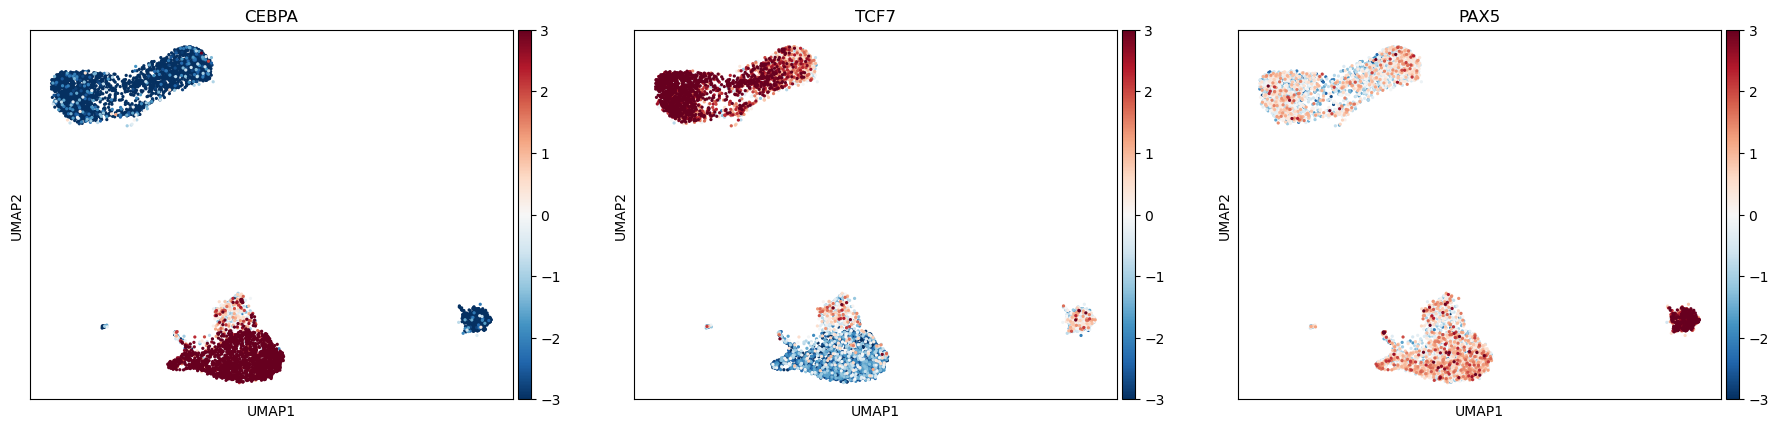

In [18]:
# First perform PCA to get PC loadings
sc.tl.pca(chromvar)

# Using PCA embedding for UMAP projection
from cuml import UMAP
vec = UMAP(metric='cosine').fit_transform(chromvar.obsm["X_pca"])
chromvar.obsm['X_umap'] = vec

# Visualize clusters and cell-type-specific TF motif scores
sc.pl.umap(chromvar, color=['CEBPA', 'TCF7', "PAX5"],cmap='RdBu_r',vmin=-3, vmax=3)

### Clustering of cells using Leiden

In [19]:
chromvar

AnnData object with n_obs × n_vars = 5543 × 1141
    uns: 'pca'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'

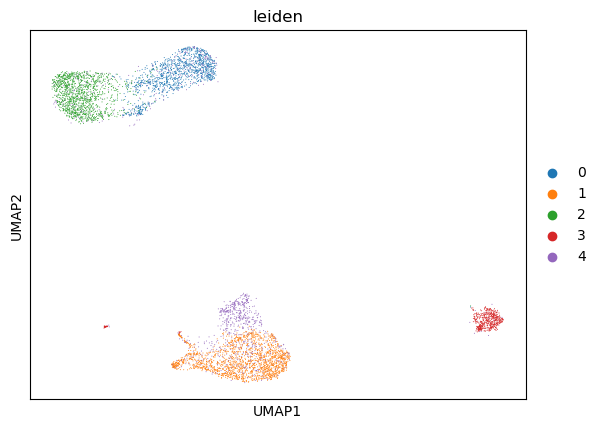

In [20]:
sc.pp.neighbors(chromvar)
sc.tl.leiden(chromvar, flavor="igraph", n_iterations=10, resolution=0.2, random_state=2)
sc.pl.umap(chromvar, color="leiden", size=2)

In [21]:
chromvar

AnnData object with n_obs × n_vars = 5543 × 1141
    obs: 'leiden'
    uns: 'pca', 'neighbors', 'leiden', 'leiden_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

### Label the cell type of each cluster

Here we label the clusters as B cells, Monocytes, and NK/T cells. In reality you can divide them into more cell types, such as different subtypes of B cells, CD14 and CD16 monocytes, a small population of DC cells, CD8/CD4 T cells etc. Here for simplicity we just group into the 3 major groups but for your own dataset you should do a more rigorous cell type annotation before you generate pseudobulks.

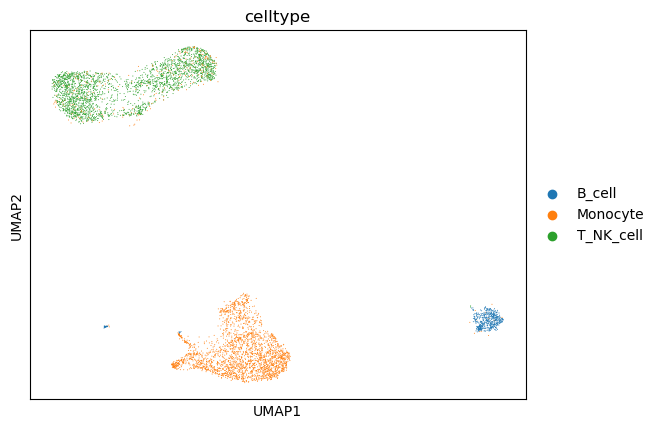

In [22]:
# Calculate the average motif score of cell type marker TFs for each cluster
cluster_score = []
marker_dict = {"TCF7":"T_NK_cell", "CEBPA":"Monocyte", "PAX5":"B_cell"}
marker_TFs = list(marker_dict.keys())
clusters = np.unique(chromvar.obs["leiden"])
for cluster in clusters:
    cell_inds = chromvar.obs["leiden"] == cluster
    cluster_score.append(np.mean(chromvar[cell_inds, marker_TFs].X, axis=0))
cluster_score = np.array(cluster_score)

# Map Leiden cluster labels to cell types
map_dict = dict({cluster:marker_dict[marker_TFs[np.argmax(cluster_score[i, :])]] for i, cluster in enumerate(clusters)})
chromvar.obs["celltype"] = [map_dict[i] for i in chromvar.obs["leiden"]]
sc.pl.umap(chromvar, color="celltype", size=2)

## Generation of pseudobulks

The generation of pseudobulks is a very flexible step. You can customize it any way to fit your research question. Here is the strategy we are using in this tutorial: For each cell type we keep sampling until we have 10 pseudobulks per cell type. Every time we first randomly sample a new cell from the cell type as the candidate pseudobulk center. We keep adding the next nearest neighbor cell from this center until we reach 5M depth. We then check if the pseudobulk mostly contains cells of the same cell type and discard impure pseudobulks. We keep iterating this process untill we have all pseudobulks generated. This is a very naive and simple approach but you might be able to find better approaches that are suitable for your dataset.

In [23]:
cell_depth = np.array(np.sum(adata.X, axis=1)).squeeze()
threshold = 5e6 # 5M totdal depth per pseudobulk. It is recommended to use the same depth for pseudobulks to prevent global biases.
pbulk_centers = []
barcode_groups = []
cell_barcodes = np.array(chromvar.obs.index)

# Fit a KNN on our cells
from sklearn.neighbors import NearestNeighbors
nbrs = NearestNeighbors(n_neighbors=chromvar.shape[0], algorithm='ball_tree').fit(chromvar.obsm["X_pca"])

# Go through each cell type
for celltype in np.unique(chromvar.obs["celltype"]):
    celltype_center_count = 0
    cell_inds = np.where(chromvar.obs["celltype"] == celltype)[0]

    # Keep sampling new pseudobulk centers untill we have 10 centers per cell type
    while celltype_center_count < 10:

        # Generate a new pseudobulk center by random sampling
        new_center = np.random.choice(cell_inds, 1)[0]

        # Sort cells by their distance to the center cell
        distances, indices = nbrs.kneighbors([chromvar.obsm["X_pca"][new_center, :]])

        # Keep adding the next nearest neighbor from the center cell to the pseudo bulk until we reach a depth threshold
        nbr_inds = indices[0, :]
        cumulative_depth = np.cumsum(cell_depth[nbr_inds])
        n_members = np.min(np.where(cumulative_depth > threshold)[0])
        pbulk_members = nbr_inds[:n_members]

        # Calculate purity of pseudobulk: percentage of the dominant cell type
        celltype_labels = chromvar.obs["celltype"][pbulk_members]
        purity = sum(celltype_labels == stat.mode(celltype_labels))/len(celltype_labels)        

        # Discard the current pseudobulk if it's impure (mixture of different cell types)
        if purity < 0.99:
            continue

        # Append the new pseudobulk to the list
        pbulk_centers.append(new_center)
        celltype_center_count += 1
        center_ind = len(pbulk_centers)
        chromvar.obs[f"pbulk_{center_ind}_member"] = np.zeros(chromvar.shape[0])
        chromvar.obs[f"pbulk_{center_ind}_member"][pbulk_members] = 1
        new_bc_group = pd.DataFrame({"barcode":cell_barcodes[pbulk_members], "group":f"{celltype}_pbulk_{celltype_center_count}"})
        barcode_groups.append(new_bc_group)
barcode_groups = pd.concat(barcode_groups, axis=0)
np.array(pbulk_centers)

array([4847,  550, 3646, 1830,  913, 5119, 4619, 1153,  163,  679, 1634,
       5418, 4492, 2571, 2677, 5009, 2986,  640,  938,  804,  757, 3353,
       2613, 2522, 1159, 5477, 2301, 5415,  896,  528])

In [24]:
barcode_groups

,barcode,group
0,TGCATGAGTGCATCAT-1,B_cell_pbulk_1
1,GTTACTTTCGACCCGA-1,B_cell_pbulk_1
2,CACCTTGCAATGTAAG-1,B_cell_pbulk_1
3,TAGCATGAGATCGCCC-1,B_cell_pbulk_1
4,TCAGGGCGTTTCGATG-1,B_cell_pbulk_1
...,...,...
363,GCAGATTAGGTAAGCC-1,T_NK_cell_pbulk_10
364,CGCTGGATCTGTCGGG-1,T_NK_cell_pbulk_10
365,CAATCCCGTGTGCTTA-1,T_NK_cell_pbulk_10
366,AAAGGATTCATTGCCC-1,T_NK_cell_pbulk_10


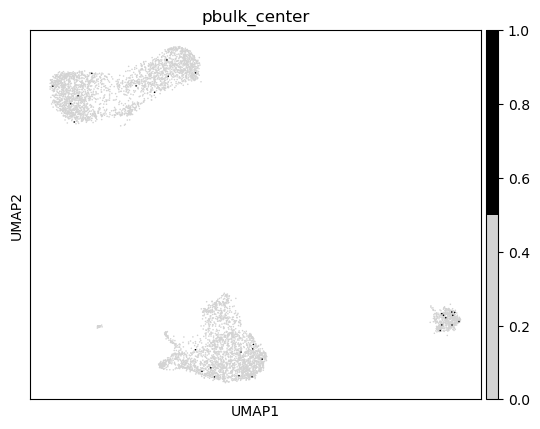

In [25]:
# Plot pseudo-bulk centers on UMAP (black dots are pseudobulk centers)
chromvar.obs["pbulk_center"] = np.zeros(chromvar.shape[0]) 
chromvar.obs["pbulk_center"][pbulk_centers] = 1
import matplotlib.colors as mcolors
cmap = mcolors.ListedColormap(['#D3D3D3', 'black'])
sc.pl.umap(chromvar, color="pbulk_center", size=5, cmap=cmap)

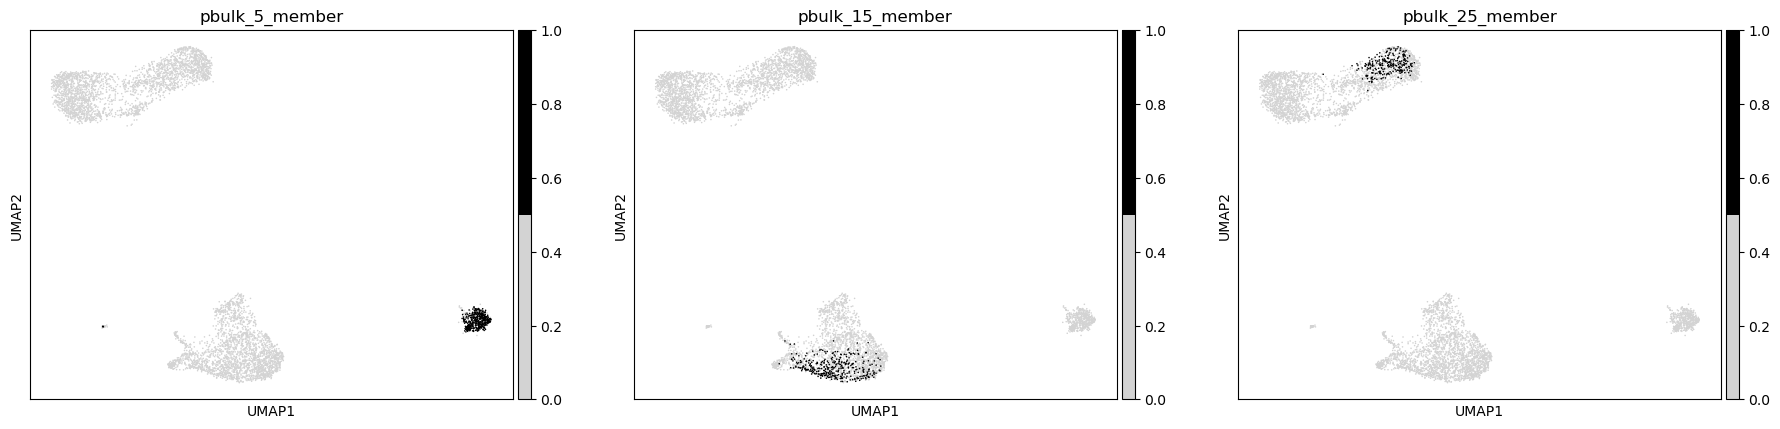

In [26]:
# Plot members of example pseudobulks (black dots are pseudobulk member cells)
sc.pl.umap(chromvar, color=["pbulk_5_member", "pbulk_15_member", "pbulk_25_member"], size=5, cmap=cmap)

## Training and analyses regarding seq2PRINT trained on the pseudobulk of all cells

We first train a bulk model using all cells, which will be used as the base model for LoRA fine-tuning on individual pseudobulks later

In [27]:
# Now we generate the config files for training seq2PRINT
import json
model_configs = []
if not os.path.exists(os.path.join(work_dir, 'configs')):
    os.makedirs(os.path.join(work_dir, 'configs'))
for fold in range(5):
    model_config= scp.tl.seq_model_config(printer,
                                     region_path=f'{work_dir}/seq2print_cleaned_narrowPeak.bed',
                                     cell_grouping=printer.obs_names,
                                     group_names='PBMC_Bulk',
                                     genome=printer.genome,
                                     fold=fold,
                                     overwrite_bigwig=False,
                                     model_name='PBMC_Bulk',
                                     additional_config={
                                        "notes": "v3",
                                        "tags": ["PBMC",
                                            "Bulk",
                                            f"fold{fold}"]},
                                     path_swap=(work_dir, ''),
                                     config_save_path=f'{work_dir}/configs/PBMC_fold{fold}.JSON')
    model_configs.append(model_config)

Creating bigwig for PBMC_Bulk


  0%|          | 0/24 [00:00<?, ?it/s]

bigwig for PBMC_Bulk already exists, skip
bigwig for PBMC_Bulk already exists, skip
bigwig for PBMC_Bulk already exists, skip
bigwig for PBMC_Bulk already exists, skip


Below we generate the commands to run in the terminal to launch our training process. Before launching the training process, it is recommended to install wandb and use it to track the training process. You can first register an account on https://wandb.ai/, then you can activate your mamba/conda environment such as ```mamba activate scprinter```, and install wandb using ```mamba install wandb```. Then you can login via ```wandb login```. This will connect your mamba/conda env with your wandb account. More information on wandb can be found in their quick start guide at https://docs.wandb.ai/quickstart/

Before running the generated commands, you can run ```nvtop``` first to check which GPUs are available. This is especially important when you share the same server with other users. The training job is rather computational intensive and usually one job could take a whole GPU and run overnight. Therefore, we recommend you manually set the CUDA_VISIBLE_DEVICES in the commands to the fully free GPUs.

When you run the command in the terminal, make sure you are in the scprinter mamba environment. To run multiple training jobs in parallel you can add ```&``` to the end of each command, such as ```CUDA_VISIBLE_DEVICES=0 seq2print_train --config /data/mhorlbec/250204_scPrinter_tutorial/PBMC_scATAC_Tutorial//seq2print/configs/PBMC_fold0.JSON --temp_dir /data/mhorlbec/250204_scPrinter_tutorial/PBMC_scATAC_Tutorial//seq2print/temp --model_dir /data/mhorlbec/250204_scPrinter_tutorial/PBMC_scATAC_Tutorial//seq2print/model --data_dir /data/mhorlbec/250204_scPrinter_tutorial/PBMC_scATAC_Tutorial//seq2print --project scPrinter_seq_PBMC --enable_wandb &```

In [29]:
for path in ['temp','model']:
    if not os.path.exists(os.path.join(work_dir, path)):
        os.makedirs(os.path.join(work_dir, path))

for fold in range(5):
    scp.tl.launch_seq2print(model_config_path=f'{work_dir}/configs/PBMC_fold{fold}.JSON',
                            temp_dir=f'{work_dir}/temp',
                            model_dir=f'{work_dir}/model',
                            data_dir=work_dir,
                            gpus=fold, # Change this if you want to specify GPUs to use
                            wandb_project='scPrinter_seq_PBMC_scATAC', # wandb helps you manage loggins
                            verbose=False,
                            launch=False # launch=True, this command would launch the scripts directly,
                            # otherwise, it will just display the commands, you should copy them and run them.
                           )

CUDA_VISIBLE_DEVICES=0 seq2print_train --config /ewsc/zhangruo/250204_scPrinter_tutorial/PBMC_scATAC_tutorial//seq2print/configs/PBMC_fold0.JSON --temp_dir /ewsc/zhangruo/250204_scPrinter_tutorial/PBMC_scATAC_tutorial//seq2print/temp --model_dir /ewsc/zhangruo/250204_scPrinter_tutorial/PBMC_scATAC_tutorial//seq2print/model --data_dir /ewsc/zhangruo/250204_scPrinter_tutorial/PBMC_scATAC_tutorial//seq2print --project scPrinter_seq_PBMC_scATAC --enable_wandb
CUDA_VISIBLE_DEVICES=1 seq2print_train --config /ewsc/zhangruo/250204_scPrinter_tutorial/PBMC_scATAC_tutorial//seq2print/configs/PBMC_fold1.JSON --temp_dir /ewsc/zhangruo/250204_scPrinter_tutorial/PBMC_scATAC_tutorial//seq2print/temp --model_dir /ewsc/zhangruo/250204_scPrinter_tutorial/PBMC_scATAC_tutorial//seq2print/model --data_dir /ewsc/zhangruo/250204_scPrinter_tutorial/PBMC_scATAC_tutorial//seq2print --project scPrinter_seq_PBMC_scATAC --enable_wandb
CUDA_VISIBLE_DEVICES=2 seq2print_train --config /ewsc/zhangruo/250204_scPrinter_

## Using the cell embeddings for LoRA fintune seq2PRINT models

In [32]:
# Now fetch models:
import wandb

# Login to your W&B account
wandb.login()

# Set your entity and project
entity = 'ruochiz'  # Replace with your W&B entity (username or team name)
project = 'scPrinter_seq_PBMC_scATAC'  # Replace with your W&B project name

# Initialize the API
api = wandb.Api()

# Get the project
runs = api.runs(f"{entity}/{project}")

model_path = []
pretrain_models = []
for run in runs:
    if run.state != 'finished':
        continue
    
    if 'PBMC' in run.tags and "Bulk" in run.tags:
        model_name = run.config['savename'] + '-' + run.name + '.pt'
        model_path.append(os.path.join(work_dir, "model", model_name))
        pretrain_models.append(model_name)
model_path

['/ewsc/zhangruo/250204_scPrinter_tutorial/PBMC_scATAC_tutorial//seq2print/model/PBMC_Bulk_fold4-happy-darkness-12.pt',
 '/ewsc/zhangruo/250204_scPrinter_tutorial/PBMC_scATAC_tutorial//seq2print/model/PBMC_Bulk_fold0-twilight-violet-11.pt',
 '/ewsc/zhangruo/250204_scPrinter_tutorial/PBMC_scATAC_tutorial//seq2print/model/PBMC_Bulk_fold3-deft-wind-11.pt',
 '/ewsc/zhangruo/250204_scPrinter_tutorial/PBMC_scATAC_tutorial//seq2print/model/PBMC_Bulk_fold2-desert-river-11.pt',
 '/ewsc/zhangruo/250204_scPrinter_tutorial/PBMC_scATAC_tutorial//seq2print/model/PBMC_Bulk_fold1-icy-glitter-11.pt']

In [33]:
cell_grouping, group_names = scp.utils.df2cell_grouping(printer, barcode_groups)

In [34]:
lora_configs = []
embeddings = pd.DataFrame(chromvar.obsm["X_pca"], index=cell_barcodes)
for fold, model in enumerate(pretrain_models):
    lora_config = scp.tl.seq_lora_model_config(printer,
                                            region_path=f'{work_dir}/seq2print_cleaned_narrowPeak.bed',
                                            cell_grouping=cell_grouping,
                                            group_names=group_names,
                                            embeddings=embeddings,
                                            genome=genome,
                                            pretrain_model=f'{work_dir}/model/{model}',
                                            overwrite_barcode=False,
                                            model_name=f'PBMC_LoRA',
                                            fold=fold,
                                            model_config=f'{work_dir}/configs/PBMC_fold{fold}.JSON',
                                            additional_lora_config={
                                            "lr":3e-5, # put smaller lr for further fintune
                                            "notes": "v3",
                                            "tags": ["PBMC", "LoRA", f"fold{fold}"]},
                                            path_swap=(work_dir, ''),
                                            config_save_path=f'{work_dir}/configs/PBMC_LoRA_fold{fold}.JSON')
    lora_configs.append(lora_config)

Similar to before, we generate the terminal commands to run. Also check ```nvtop``` to select available GPUs and add ```&``` at the end of each command to run them in parallel.

In [35]:
for fold in range(5):
    scp.tl.launch_seq2print(model_config_path=f'{work_dir}/configs/PBMC_LoRA_fold{fold}.JSON',
                            temp_dir=f'{work_dir}/temp',
                            model_dir=f'{work_dir}/model',
                            data_dir=work_dir,
                            gpus=fold,
                            wandb_project='scPrinter_seq_PBMC_scATAC', 
                            verbose=False, 
                            launch=False)

CUDA_VISIBLE_DEVICES=0 seq2print_train --config /ewsc/zhangruo/250204_scPrinter_tutorial/PBMC_scATAC_tutorial//seq2print/configs/PBMC_LoRA_fold0.JSON --temp_dir /ewsc/zhangruo/250204_scPrinter_tutorial/PBMC_scATAC_tutorial//seq2print/temp --model_dir /ewsc/zhangruo/250204_scPrinter_tutorial/PBMC_scATAC_tutorial//seq2print/model --data_dir /ewsc/zhangruo/250204_scPrinter_tutorial/PBMC_scATAC_tutorial//seq2print --project scPrinter_seq_PBMC_scATAC --enable_wandb
CUDA_VISIBLE_DEVICES=1 seq2print_train --config /ewsc/zhangruo/250204_scPrinter_tutorial/PBMC_scATAC_tutorial//seq2print/configs/PBMC_LoRA_fold1.JSON --temp_dir /ewsc/zhangruo/250204_scPrinter_tutorial/PBMC_scATAC_tutorial//seq2print/temp --model_dir /ewsc/zhangruo/250204_scPrinter_tutorial/PBMC_scATAC_tutorial//seq2print/model --data_dir /ewsc/zhangruo/250204_scPrinter_tutorial/PBMC_scATAC_tutorial//seq2print --project scPrinter_seq_PBMC_scATAC --enable_wandb
CUDA_VISIBLE_DEVICES=2 seq2print_train --config /ewsc/zhangruo/250204_

## Use seq2PRINT to compute TF binding scores

In [36]:
# Now fetch models:
import wandb

# Login to your W&B account
wandb.login()

# Set your entity and project
entity = 'ruochiz'  # Replace with your W&B entity (username or team name)
project = 'scPrinter_seq_PBMC_scATAC'  # Replace with your W&B project name

# Initialize the API
api = wandb.Api()

# Get the project
runs = api.runs(f"{entity}/{project}")

lora_models = []
for run in runs:
    if run.state != 'finished':
        continue
    if 'LoRA' in run.tags:
        model_name = run.config['savename'] + '-' + run.name + '.pt'
        lora_models.append(model_name)

lora_model_path = [os.path.join(work_dir, "model", m) for m in lora_models]

In [37]:
lora_model_path 

['/ewsc/zhangruo/250204_scPrinter_tutorial/PBMC_scATAC_tutorial//seq2print/model/PBMC_LoRA_fold2-resilient-jazz-17.pt',
 '/ewsc/zhangruo/250204_scPrinter_tutorial/PBMC_scATAC_tutorial//seq2print/model/PBMC_LoRA_fold3-daily-resonance-16.pt',
 '/ewsc/zhangruo/250204_scPrinter_tutorial/PBMC_scATAC_tutorial//seq2print/model/PBMC_LoRA_fold1-ethereal-paper-16.pt',
 '/ewsc/zhangruo/250204_scPrinter_tutorial/PBMC_scATAC_tutorial//seq2print/model/PBMC_LoRA_fold0-light-glitter-16.pt',
 '/ewsc/zhangruo/250204_scPrinter_tutorial/PBMC_scATAC_tutorial//seq2print/model/PBMC_LoRA_fold4-dry-river-16.pt']

### Compute TF binding scores for a few example regions

We first select a few example promoter regions that potentially show cell-type specific expression. Let's examine whether seq2PRINT infers differential TF binding at these regions. 

In [38]:
regions_dict = {
    'chr11:47378230-47379030': 'SPI1', # Highly expressed in monocytes and B cells
    'chr5:140633035-140633835': 'CD14', # Monocyte marker
    'chr19:41876833-41877633': 'CD79A', # B cell marker
    'chr11:118342294-118343094': 'CD3D', # T cell marker
    'chr17:58281312-58282112': 'MPO', # Monocyte marker
    'chr16:31259594-31260394': 'ITGAM', # CD11b, Expressed in myeloid cells (including monocyte)
    'chr3:39281281-39282081': 'CX3CR1', # A pretty important gene driving disease-related monocyte cell states
}

# Save example regions to a bed file
regions_df = []
for region in regions_dict:
    regions_df.append(re.split("[:-]", region))
regions_df = pd.DataFrame(regions_df)
regions_df.to_csv(f'{work_dir}/regions_test.bed',
                  sep='\t', header=False, index=False)

Below we launch the compute for TF binding scores. When we are only testing on a small number of regions or pseudobulks, we can set return_adata to be True so that the results can be returned also in an anndata object. If the number of regions or pseudobulks is big please set it to False so it doesn't take up all the memory.

Remember to check nvtop to select available GPUs using the "gpus" argument.

Note that here we are using ```model_path=lora_model_path[0]``` Which only uses 1 out of the 5 fold models we trained. You can also provide ```model_path=lora_model_path``` Which will use all five fold models. Using all 5 folds will slightly increase accuracy but will take a much longer time. We recommend using only 1 fold for exploratory anlaysis and all 5 folds for final publication.

In [40]:
import json
adata_tfbs = scp.tl.seq_tfbs_seq2print(seq_attr_count=None,
                      seq_attr_footprint=None,
                      genome=printer.genome,
                      region_path=f'{work_dir}/regions_test.bed',
                      gpus=[0,1,2,3,4,5,6],
                      model_type='lora',
                      model_path=lora_model_path[0], # For now we just run on one fold
                      lora_config=json.load(open(f'{work_dir}/configs/PBMC_LoRA_fold0.JSON', 'r')),
                      group_names=list(group_names),
                      verbose=False,
                      launch=True,
                      return_adata=True,
                      overwrite_seqattr=True,
                      save_key='PBMC_LoRA_test', # and input a save_key
                      save_path=work_dir)

group_names [['B_cell_pbulk_1'], ['B_cell_pbulk_10'], ['B_cell_pbulk_2'], ['B_cell_pbulk_3'], ['B_cell_pbulk_4'], ['B_cell_pbulk_5'], ['B_cell_pbulk_6'], ['B_cell_pbulk_7'], ['B_cell_pbulk_8'], ['B_cell_pbulk_9'], ['Monocyte_pbulk_1'], ['Monocyte_pbulk_10'], ['Monocyte_pbulk_2'], ['Monocyte_pbulk_3'], ['Monocyte_pbulk_4'], ['Monocyte_pbulk_5'], ['Monocyte_pbulk_6'], ['Monocyte_pbulk_7'], ['Monocyte_pbulk_8'], ['Monocyte_pbulk_9'], ['T_NK_cell_pbulk_1'], ['T_NK_cell_pbulk_10'], ['T_NK_cell_pbulk_2'], ['T_NK_cell_pbulk_3'], ['T_NK_cell_pbulk_4'], ['T_NK_cell_pbulk_5'], ['T_NK_cell_pbulk_6'], ['T_NK_cell_pbulk_7'], ['T_NK_cell_pbulk_8'], ['T_NK_cell_pbulk_9']]
save_group_names B_cell_pbulk_1,B_cell_pbulk_10,B_cell_pbulk_2,B_cell_pbulk_3,B_cell_pbulk_4,B_cell_pbulk_5,B_cell_pbulk_6,B_cell_pbulk_7,B_cell_pbulk_8,B_cell_pbulk_9,Monocyte_pbulk_1,Monocyte_pbulk_10,Monocyte_pbulk_2,Monocyte_pbulk_3,Monocyte_pbulk_4,Monocyte_pbulk_5,Monocyte_pbulk_6,Monocyte_pbulk_7,Monocyte_pbulk_8,Monocyte_pbu

working on T_NK_cell_pbulk_6:   0%|          | 0/4 [00:00<?, ?it/s]

[['0'], ['1'], ['2'], ['3'], ['4']] [['0'], ['1'], ['2'], ['3'], ['4']]
[[0], [1], [2], [3], [4]]
[0]
setting coverage to be the same
signal_window 1000 dna_len 1840
input summits 7
valid summits after trimming edges 7
(7, 1)
coverage min max 891.96387 960.1363
valid summits after min/max count filter 7


working on B_cell_pbulk_1:   0%|          | 0/5 [00:00<?, ?it/s]

[['10'], ['11'], ['12'], ['13']] [['10'], ['11'], ['12'], ['13']]
[[10], [11], [12], [13]]
[2]
setting coverage to be the same
signal_window 1000 dna_len 1840
input summits 7
valid summits after trimming edges 7
(7, 1)
coverage min max 891.96387 960.1363
valid summits after min/max count filter 7
[['5'], ['6'], ['7'], ['8'], ['9']] [['5'], ['6'], ['7'], ['8'], ['9']]
[[5], [6], [7], [8], [9]]
[1]
setting coverage to be the same
signal_window 1000 dna_len 1840
input summits 7
valid summits after trimming edges 7
(7, 1)
coverage min max 891.96387 960.1363
valid summits after min/max count filter 7


working on Monocyte_pbulk_4:   0%|          | 0/4 [00:00<?, ?it/s]

[['14'], ['15'], ['16'], ['17']] [['14'], ['15'], ['16'], ['17']]
[[14], [15], [16], [17]]
[3]
setting coverage to be the same
signal_window 1000 dna_len 1840
input summits 7
valid summits after trimming edges 7
(7, 1)
coverage min max 891.96387 960.1363
valid summits after min/max count filter 7
[['22'], ['23'], ['24'], ['25']] [['22'], ['23'], ['24'], ['25']]
[[22], [23], [24], [25]]
[5]
setting coverage to be the same
signal_window 1000 dna_len 1840
input summits 7
valid summits after trimming edges 7
(7, 1)
coverage min max 891.96387 960.1363
valid summits after min/max count filter 7
[['18'], ['19'], ['20'], ['21']] [['18'], ['19'], ['20'], ['21']]
[[18], [19], [20], [21]]
[4]
setting coverage to be the same
signal_window 1000 dna_len 1840
input summits 7
valid summits after trimming edges 7
(7, 1)
coverage min max 891.96387 960.1363
valid summits after min/max count filter 7


working on B_cell_pbulk_4:  80%|████████  | 4/5 [00:06<00:01,  1.62s/it]/it]

saving attrs
using pre-calculated norm key count
filename_template model_T_NK_cell_pbulk_6.{type}.count.shap_hypo_0_.0.85.
model_T_NK_cell_pbulk_6.hypo.count.shap_hypo_0_.0.85.npz
saving attrs
using pre-calculated norm key count
filename_template model_T_NK_cell_pbulk_7.{type}.count.shap_hypo_0_.0.85.
model_T_NK_cell_pbulk_7.hypo.count.shap_hypo_0_.0.85.npz
saving attrs
using pre-calculated norm key count
filename_template model_T_NK_cell_pbulk_8.{type}.count.shap_hypo_0_.0.85.
model_T_NK_cell_pbulk_8.hypo.count.shap_hypo_0_.0.85.npz
saving attrs
using pre-calculated norm key count
filename_template model_T_NK_cell_pbulk_9.{type}.count.shap_hypo_0_.0.85.
model_T_NK_cell_pbulk_9.hypo.count.shap_hypo_0_.0.85.npz


working on B_cell_pbulk_9:  80%|████████  | 4/5 [00:06<00:01,  1.61s/it]

saving attrs
using pre-calculated norm key count
filename_template model_Monocyte_pbulk_1.{type}.count.shap_hypo_0_.0.85.
model_Monocyte_pbulk_1.hypo.count.shap_hypo_0_.0.85.npz
saving attrs
using pre-calculated norm key count
filename_template model_Monocyte_pbulk_10.{type}.count.shap_hypo_0_.0.85.
model_Monocyte_pbulk_10.hypo.count.shap_hypo_0_.0.85.npz
saving attrs
using pre-calculated norm key count
filename_template model_Monocyte_pbulk_2.{type}.count.shap_hypo_0_.0.85.
model_Monocyte_pbulk_2.hypo.count.shap_hypo_0_.0.85.npz
saving attrs
using pre-calculated norm key count
filename_template model_Monocyte_pbulk_3.{type}.count.shap_hypo_0_.0.85.
model_Monocyte_pbulk_3.hypo.count.shap_hypo_0_.0.85.npz
saving attrs
using pre-calculated norm key count
filename_template model_Monocyte_pbulk_4.{type}.count.shap_hypo_0_.0.85.
model_Monocyte_pbulk_4.hypo.count.shap_hypo_0_.0.85.npz
saving attrs
using pre-calculated norm key count
filename_template model_Monocyte_pbulk_5.{type}.count.shap_

working on B_cell_pbulk_4: 100%|██████████| 5/5 [00:08<00:00,  1.66s/it]


saving attrs
using pre-calculated norm key count
filename_template model_T_NK_cell_pbulk_2.{type}.count.shap_hypo_0_.0.85.
model_T_NK_cell_pbulk_2.hypo.count.shap_hypo_0_.0.85.npz
saving attrs
using pre-calculated norm key count
filename_template model_T_NK_cell_pbulk_3.{type}.count.shap_hypo_0_.0.85.
model_T_NK_cell_pbulk_3.hypo.count.shap_hypo_0_.0.85.npz
saving attrs
using pre-calculated norm key count
filename_template model_T_NK_cell_pbulk_4.{type}.count.shap_hypo_0_.0.85.
model_T_NK_cell_pbulk_4.hypo.count.shap_hypo_0_.0.85.npz
saving attrs
using pre-calculated norm key count
filename_template model_T_NK_cell_pbulk_5.{type}.count.shap_hypo_0_.0.85.
model_T_NK_cell_pbulk_5.hypo.count.shap_hypo_0_.0.85.npz
saving attrs
using pre-calculated norm key count
filename_template model_Monocyte_pbulk_8.{type}.count.shap_hypo_0_.0.85.
model_Monocyte_pbulk_8.hypo.count.shap_hypo_0_.0.85.npz
saving attrs
using pre-calculated norm key count
filename_template model_Monocyte_pbulk_9.{type}.count

working on B_cell_pbulk_9: 100%|██████████| 5/5 [00:08<00:00,  1.65s/it]


saving attrs
using pre-calculated norm key count
filename_template model_B_cell_pbulk_5.{type}.count.shap_hypo_0_.0.85.
model_B_cell_pbulk_5.hypo.count.shap_hypo_0_.0.85.npz
saving attrs
using pre-calculated norm key count
filename_template model_B_cell_pbulk_6.{type}.count.shap_hypo_0_.0.85.
model_B_cell_pbulk_6.hypo.count.shap_hypo_0_.0.85.npz
saving attrs
using pre-calculated norm key count
filename_template model_B_cell_pbulk_7.{type}.count.shap_hypo_0_.0.85.
model_B_cell_pbulk_7.hypo.count.shap_hypo_0_.0.85.npz
saving attrs
using pre-calculated norm key count
filename_template model_B_cell_pbulk_8.{type}.count.shap_hypo_0_.0.85.
model_B_cell_pbulk_8.hypo.count.shap_hypo_0_.0.85.npz
saving attrs
using pre-calculated norm key count
filename_template model_B_cell_pbulk_9.{type}.count.shap_hypo_0_.0.85.
model_B_cell_pbulk_9.hypo.count.shap_hypo_0_.0.85.npz
group_names [['B_cell_pbulk_1'], ['B_cell_pbulk_10'], ['B_cell_pbulk_2'], ['B_cell_pbulk_3'], ['B_cell_pbulk_4'], ['B_cell_pbulk_5

working on T_NK_cell_pbulk_6:   0%|          | 0/4 [00:00<?, ?it/s]

[['10'], ['11'], ['12'], ['13']] [['10'], ['11'], ['12'], ['13']]
[[10], [11], [12], [13]]
[2]
setting coverage to be the same
signal_window 1000 dna_len 1840
input summits 7
valid summits after trimming edges 7
(7, 1)
coverage min max 891.96387 960.1363
valid summits after min/max count filter 7


working on Monocyte_pbulk_1:   0%|          | 0/4 [00:00<?, ?it/s]

[['14'], ['15'], ['16'], ['17']] [['14'], ['15'], ['16'], ['17']]
[[14], [15], [16], [17]]
[3]
setting coverage to be the same
signal_window 1000 dna_len 1840
input summits 7
valid summits after trimming edges 7
(7, 1)
coverage min max 891.96387 960.1363
valid summits after min/max count filter 7
[['18'], ['19'], ['20'], ['21']] [['18'], ['19'], ['20'], ['21']]
[[18], [19], [20], [21]]
[4]
setting coverage to be the same
signal_window 1000 dna_len 1840
input summits 7
valid summits after trimming edges 7
(7, 1)
coverage min max 891.96387 960.1363
valid summits after min/max count filter 7


working on Monocyte_pbulk_8:   0%|          | 0/4 [00:00<?, ?it/s]

[['22'], ['23'], ['24'], ['25']] [['22'], ['23'], ['24'], ['25']]
[[22], [23], [24], [25]]
[5]
setting coverage to be the same
signal_window 1000 dna_len 1840
input summits 7
valid summits after trimming edges 7
(7, 1)
coverage min max 891.96387 960.1363
valid summits after min/max count filter 7
[['5'], ['6'], ['7'], ['8'], ['9']] [['5'], ['6'], ['7'], ['8'], ['9']]
[[5], [6], [7], [8], [9]]
[1]
setting coverage to be the same
signal_window 1000 dna_len 1840
input summits 7
valid summits after trimming edges 7
(7, 1)
coverage min max 891.96387 960.1363
valid summits after min/max count filter 7


working on Monocyte_pbulk_6:  50%|█████     | 2/4 [00:03<00:03,  1.83s/it]]

[['0'], ['1'], ['2'], ['3'], ['4']] [['0'], ['1'], ['2'], ['3'], ['4']]
[[0], [1], [2], [3], [4]]
[0]
setting coverage to be the same
signal_window 1000 dna_len 1840
input summits 7
valid summits after trimming edges 7
(7, 1)
coverage min max 891.96387 960.1363
valid summits after min/max count filter 7


working on B_cell_pbulk_10:  20%|██        | 1/5 [00:02<00:08,  2.09s/it]

saving attrs
using pre-calculated norm key footprint
filename_template model_T_NK_cell_pbulk_6.{type}.just_sum.shap_hypo_0-30_.0.85.
model_T_NK_cell_pbulk_6.hypo.just_sum.shap_hypo_0-30_.0.85.npz
saving attrs
using pre-calculated norm key footprint
filename_template model_T_NK_cell_pbulk_7.{type}.just_sum.shap_hypo_0-30_.0.85.
model_T_NK_cell_pbulk_7.hypo.just_sum.shap_hypo_0-30_.0.85.npz
saving attrs
using pre-calculated norm key footprint
filename_template model_T_NK_cell_pbulk_8.{type}.just_sum.shap_hypo_0-30_.0.85.
model_T_NK_cell_pbulk_8.hypo.just_sum.shap_hypo_0-30_.0.85.npz
saving attrs
using pre-calculated norm key footprint
filename_template model_T_NK_cell_pbulk_9.{type}.just_sum.shap_hypo_0-30_.0.85.
model_T_NK_cell_pbulk_9.hypo.just_sum.shap_hypo_0-30_.0.85.npz


working on Monocyte_pbulk_7: 100%|██████████| 4/4 [00:06<00:00,  1.72s/it]


saving attrs
using pre-calculated norm key footprint
filename_template model_Monocyte_pbulk_1.{type}.just_sum.shap_hypo_0-30_.0.85.
model_Monocyte_pbulk_1.hypo.just_sum.shap_hypo_0-30_.0.85.npz
saving attrs
using pre-calculated norm key footprint
filename_template model_Monocyte_pbulk_10.{type}.just_sum.shap_hypo_0-30_.0.85.
model_Monocyte_pbulk_10.hypo.just_sum.shap_hypo_0-30_.0.85.npz
saving attrs
using pre-calculated norm key footprint
filename_template model_Monocyte_pbulk_2.{type}.just_sum.shap_hypo_0-30_.0.85.
model_Monocyte_pbulk_2.hypo.just_sum.shap_hypo_0-30_.0.85.npz
saving attrs
using pre-calculated norm key footprint
filename_template model_Monocyte_pbulk_3.{type}.just_sum.shap_hypo_0-30_.0.85.
model_Monocyte_pbulk_3.hypo.just_sum.shap_hypo_0-30_.0.85.npz
saving attrs
using pre-calculated norm key footprint
filename_template model_Monocyte_pbulk_8.{type}.just_sum.shap_hypo_0-30_.0.85.
model_Monocyte_pbulk_8.hypo.just_sum.shap_hypo_0-30_.0.85.npz
saving attrs
using pre-calcu

working on B_cell_pbulk_2:  40%|████      | 2/5 [00:03<00:05,  1.78s/it] 

saving attrs
using pre-calculated norm key footprint
filename_template model_T_NK_cell_pbulk_2.{type}.just_sum.shap_hypo_0-30_.0.85.
model_T_NK_cell_pbulk_2.hypo.just_sum.shap_hypo_0-30_.0.85.npz
saving attrs
using pre-calculated norm key footprint
filename_template model_T_NK_cell_pbulk_3.{type}.just_sum.shap_hypo_0-30_.0.85.
model_T_NK_cell_pbulk_3.hypo.just_sum.shap_hypo_0-30_.0.85.npz
saving attrs
using pre-calculated norm key footprint
filename_template model_T_NK_cell_pbulk_4.{type}.just_sum.shap_hypo_0-30_.0.85.
model_T_NK_cell_pbulk_4.hypo.just_sum.shap_hypo_0-30_.0.85.npz
saving attrs
using pre-calculated norm key footprint
filename_template model_T_NK_cell_pbulk_5.{type}.just_sum.shap_hypo_0-30_.0.85.
model_T_NK_cell_pbulk_5.hypo.just_sum.shap_hypo_0-30_.0.85.npz


working on B_cell_pbulk_9: 100%|██████████| 5/5 [00:08<00:00,  1.69s/it]


saving attrs
using pre-calculated norm key footprint
filename_template model_B_cell_pbulk_5.{type}.just_sum.shap_hypo_0-30_.0.85.
model_B_cell_pbulk_5.hypo.just_sum.shap_hypo_0-30_.0.85.npz
saving attrs
using pre-calculated norm key footprint
filename_template model_B_cell_pbulk_6.{type}.just_sum.shap_hypo_0-30_.0.85.
model_B_cell_pbulk_6.hypo.just_sum.shap_hypo_0-30_.0.85.npz
saving attrs
using pre-calculated norm key footprint
filename_template model_B_cell_pbulk_7.{type}.just_sum.shap_hypo_0-30_.0.85.
model_B_cell_pbulk_7.hypo.just_sum.shap_hypo_0-30_.0.85.npz
saving attrs
using pre-calculated norm key footprint
filename_template model_B_cell_pbulk_8.{type}.just_sum.shap_hypo_0-30_.0.85.
model_B_cell_pbulk_8.hypo.just_sum.shap_hypo_0-30_.0.85.npz
saving attrs
using pre-calculated norm key footprint
filename_template model_B_cell_pbulk_9.{type}.just_sum.shap_hypo_0-30_.0.85.
model_B_cell_pbulk_9.hypo.just_sum.shap_hypo_0-30_.0.85.npz


working on B_cell_pbulk_4: 100%|██████████| 5/5 [00:08<00:00,  1.67s/it]


saving attrs
using pre-calculated norm key footprint
filename_template model_B_cell_pbulk_1.{type}.just_sum.shap_hypo_0-30_.0.85.
model_B_cell_pbulk_1.hypo.just_sum.shap_hypo_0-30_.0.85.npz
saving attrs
using pre-calculated norm key footprint
filename_template model_B_cell_pbulk_10.{type}.just_sum.shap_hypo_0-30_.0.85.
model_B_cell_pbulk_10.hypo.just_sum.shap_hypo_0-30_.0.85.npz
saving attrs
using pre-calculated norm key footprint
filename_template model_B_cell_pbulk_2.{type}.just_sum.shap_hypo_0-30_.0.85.
model_B_cell_pbulk_2.hypo.just_sum.shap_hypo_0-30_.0.85.npz
saving attrs
using pre-calculated norm key footprint
filename_template model_B_cell_pbulk_3.{type}.just_sum.shap_hypo_0-30_.0.85.
model_B_cell_pbulk_3.hypo.just_sum.shap_hypo_0-30_.0.85.npz
saving attrs
using pre-calculated norm key footprint
filename_template model_B_cell_pbulk_4.{type}.just_sum.shap_hypo_0-30_.0.85.
model_B_cell_pbulk_4.hypo.just_sum.shap_hypo_0-30_.0.85.npz
seq2print_tfbs --count_pt /ewsc/zhangruo/.cache/

  0%|          | 0/35 [00:00<?, ?it/s]

gpu 4
gpu 6
gpu 5
gpu 2
gpu 3


  0%|          | 0/28 [00:00<?, ?it/s]


(5, 7, 800)
(5, 7, 800)
(4, 7, 800)
(4, 7, 800)
(4, 7, 800)


  0%|          | 0/28 [00:00<?, ?it/s]


(4, 7, 800)
(4, 7, 800)
['seq2print_tfbs', '--count_pt', '/ewsc/zhangruo/.cache/scprinter/TFBS_0_conv_v2.pt', '--foot_pt', '/ewsc/zhangruo/.cache/scprinter/TFBS_1_conv_v2.pt', '--seq_count', '/ewsc/zhangruo/250204_scPrinter_tutorial/PBMC_scATAC_tutorial//seq2print/model/PBMC_LoRA_fold2-resilient-jazz-17.pt_PBMC_LoRA_test/model_{lora_id}.attr.count.shap_hypo_0_.0.85.npz', '--seq_foot', '/ewsc/zhangruo/250204_scPrinter_tutorial/PBMC_scATAC_tutorial//seq2print/model/PBMC_LoRA_fold2-resilient-jazz-17.pt_PBMC_LoRA_test/model_{lora_id}.attr.just_sum.shap_hypo_0-30_.0.85.npz', '--genome', 'hg38', '--peaks', '/ewsc/zhangruo/250204_scPrinter_tutorial/PBMC_scATAC_tutorial//seq2print/regions_test.bed', '--gpus', '1', '--lora_ids', 'B_cell_pbulk_5,B_cell_pbulk_6,B_cell_pbulk_7,B_cell_pbulk_8,B_cell_pbulk_9', '--read_numpy', '--write_numpy', '--collection_name', '/ewsc/zhangruo/250204_scPrinter_tutorial/PBMC_scATAC_tutorial//seq2print/PBMC_LoRA_test_temp_TFBS_part1']
['seq2print_tfbs', '--count_pt'

Below you can see that seq2PRINT can predict cell-type-specific TF binding consistent with known biology

chr11:47378230-47379030 SPI1


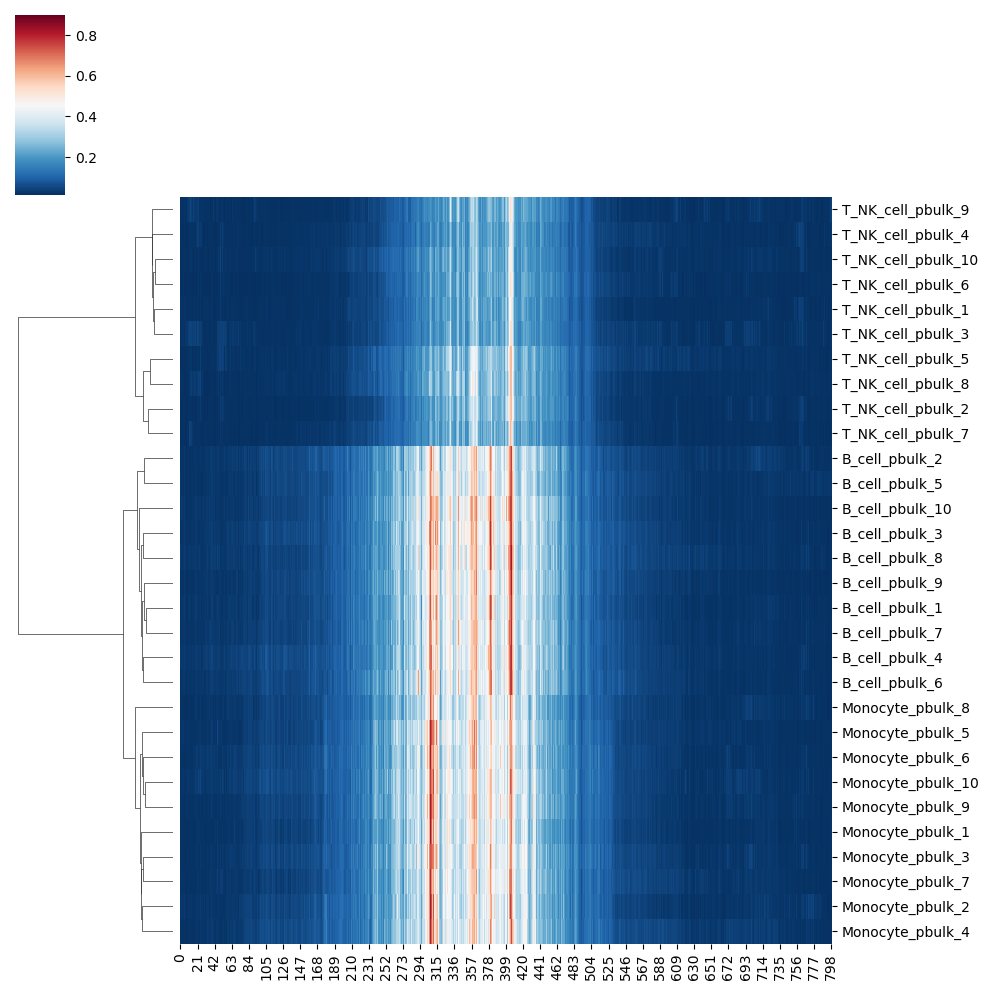

chr5:140633035-140633835 CD14


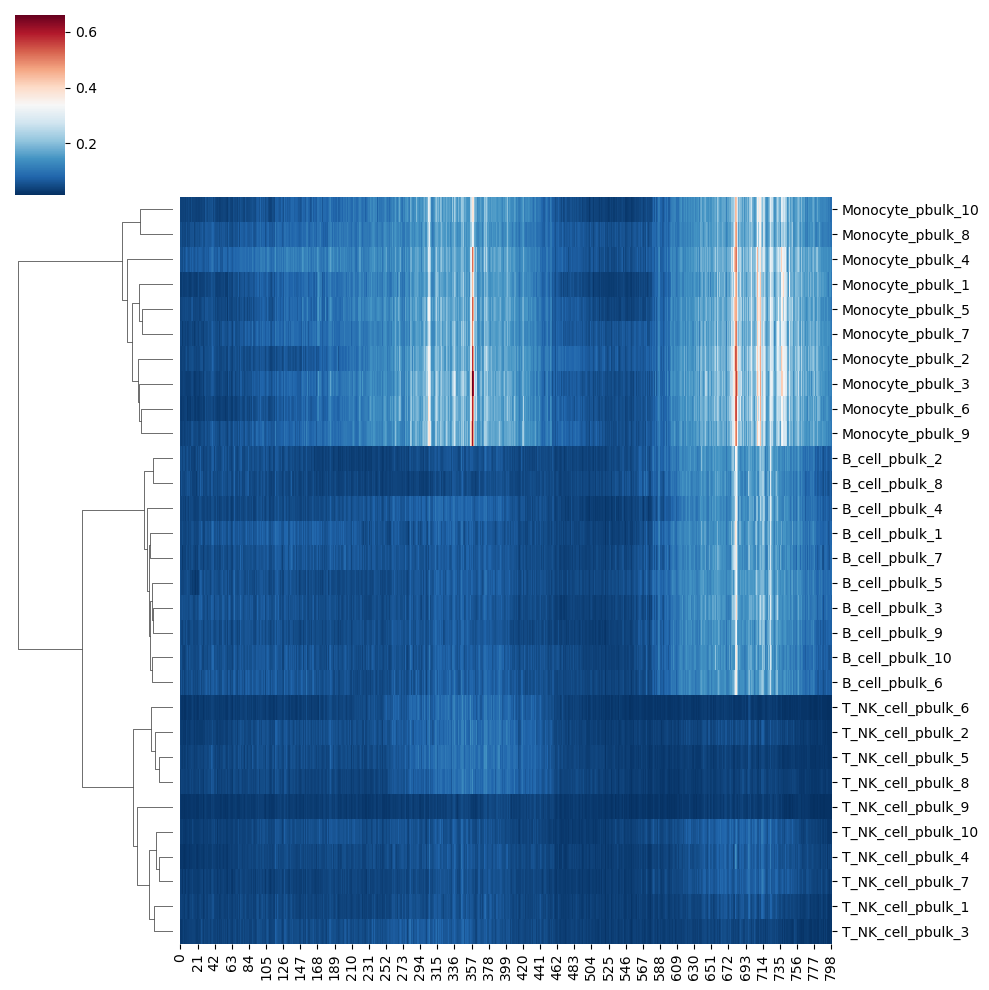

chr19:41876833-41877633 CD79A


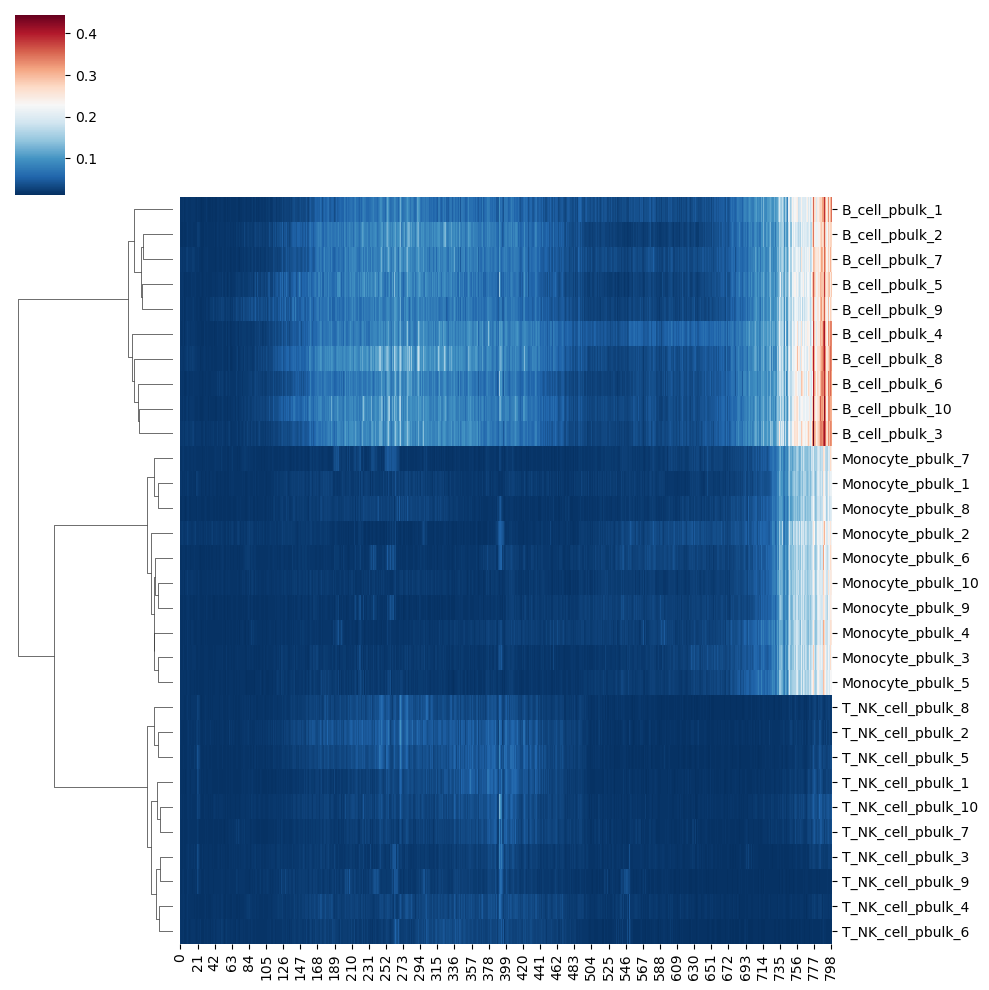

chr11:118342294-118343094 CD3D


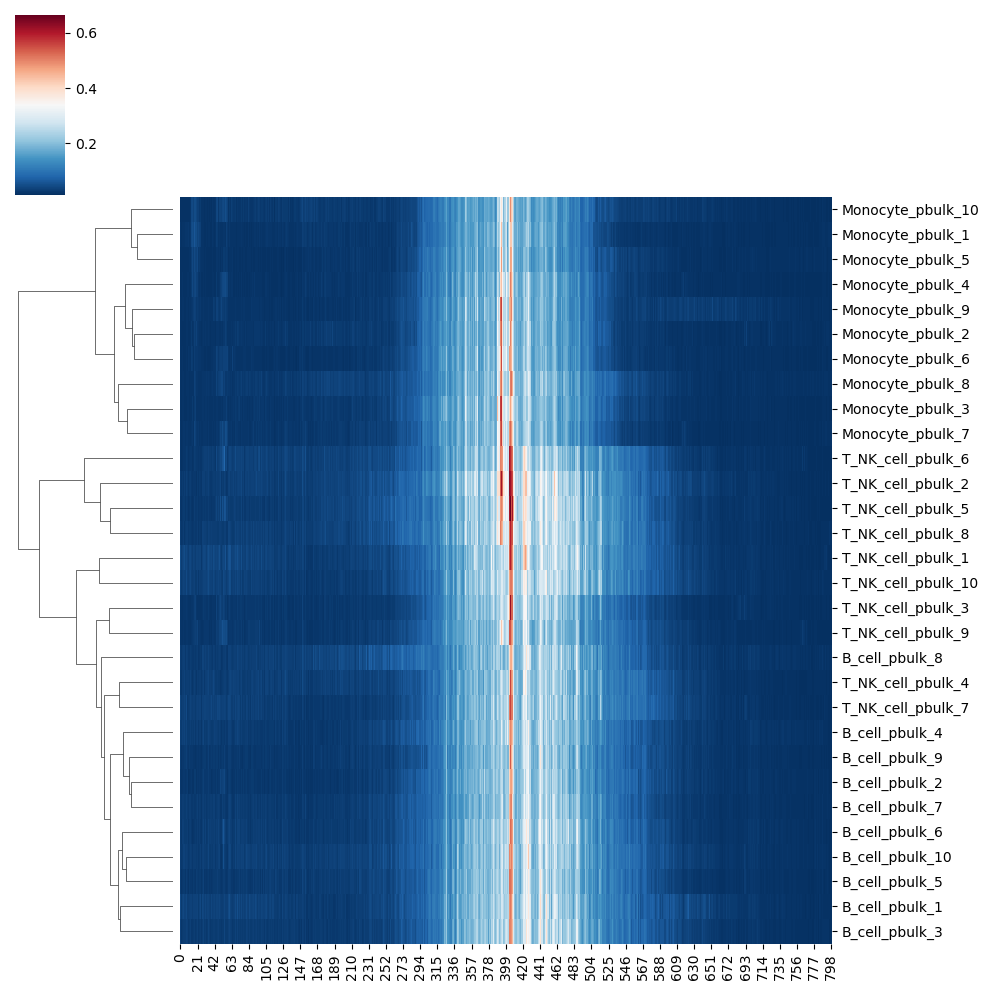

chr17:58281312-58282112 MPO


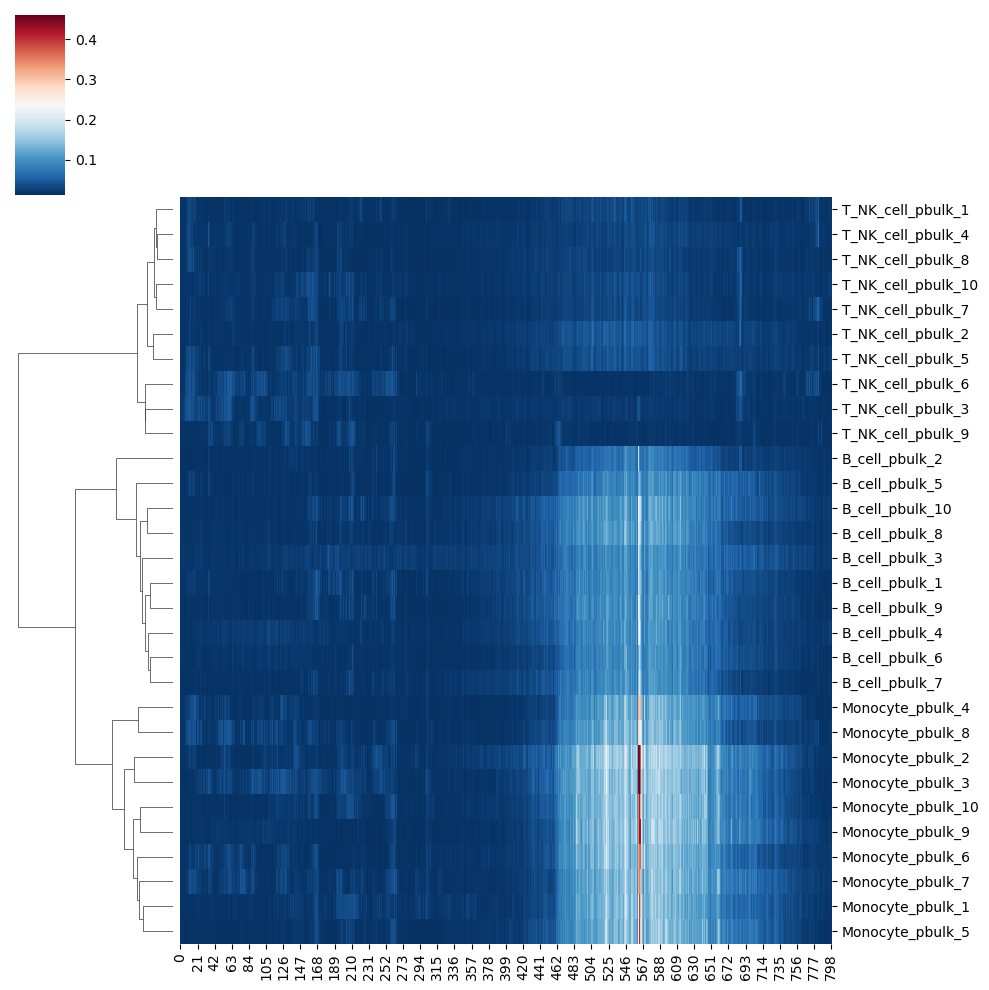

chr16:31259594-31260394 ITGAM


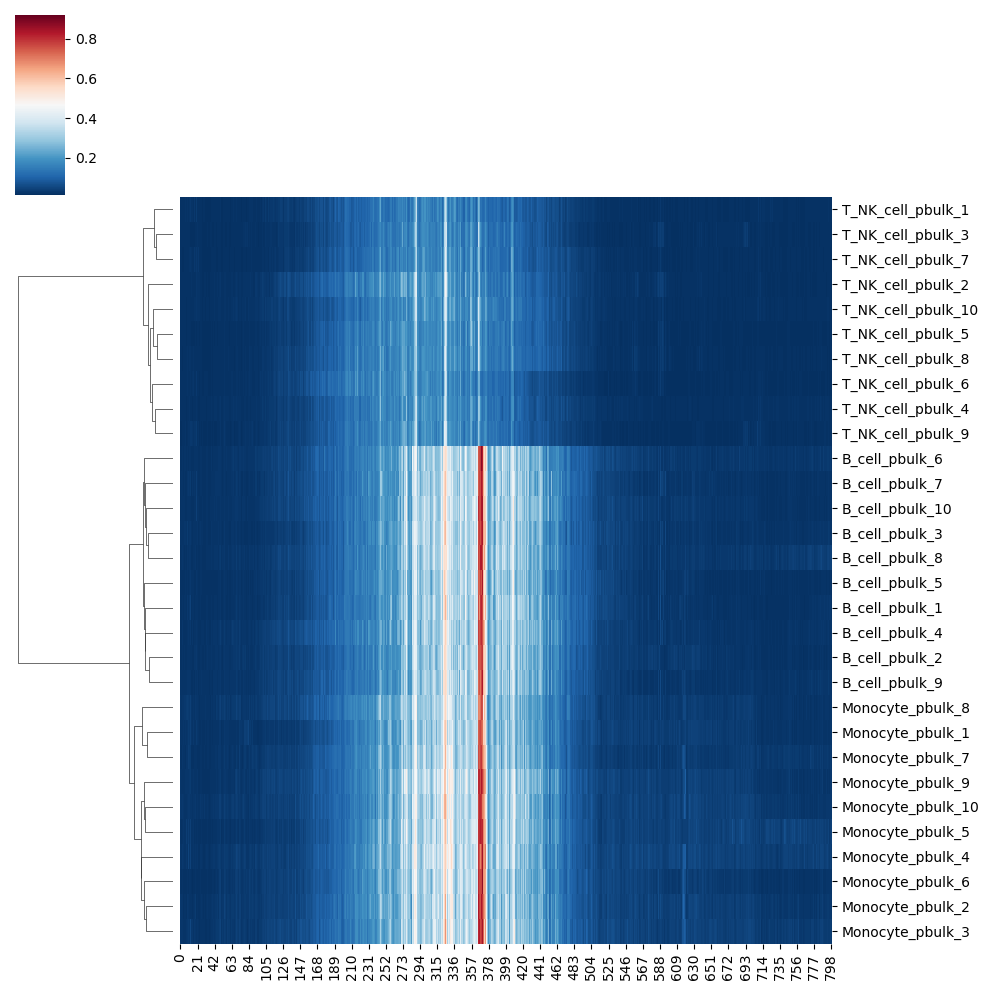

chr3:39281281-39282081 CX3CR1


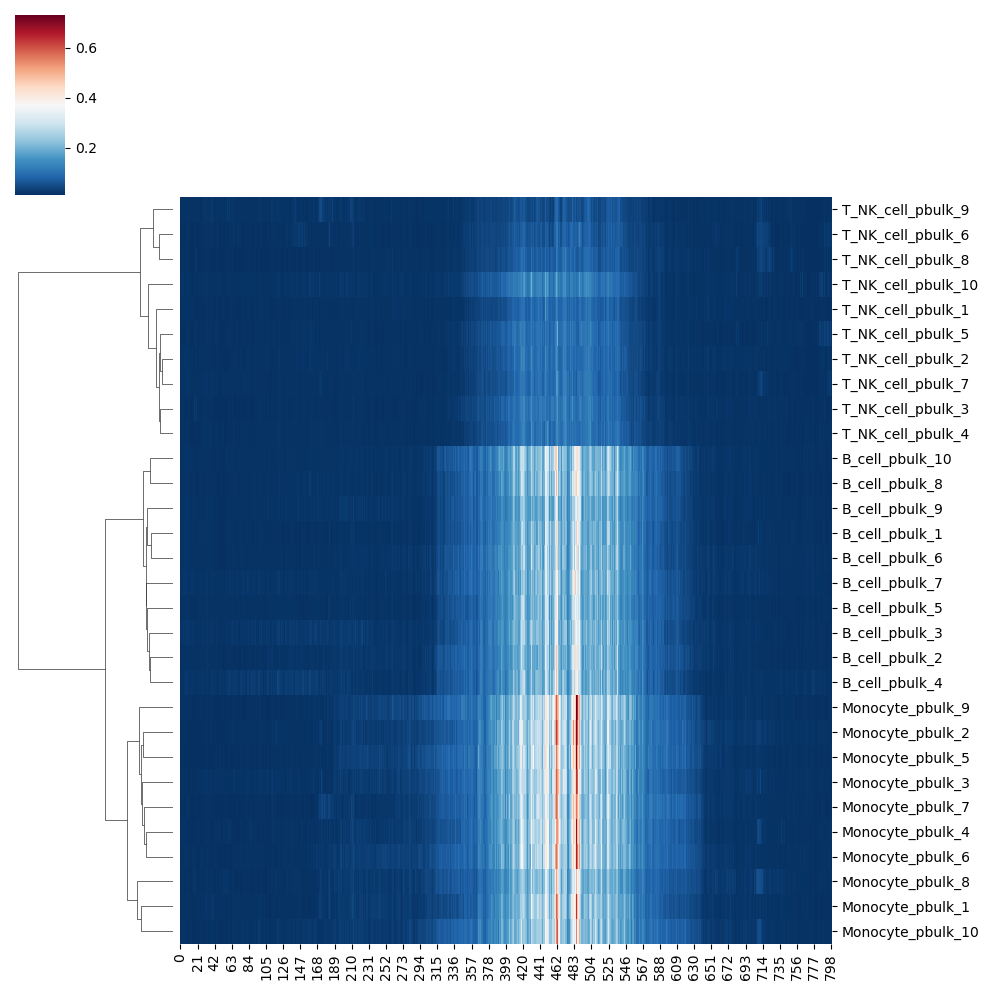

In [41]:
for region in regions_dict.keys():
    print(region, regions_dict[region])
    tfbs = pd.DataFrame(adata_tfbs.obsm[region], index=group_names)
    sns.clustermap(tfbs, cmap='RdBu_r', col_cluster=False)
    #plt.savefig(f'{work_dir}/plots/TFBS_{region}.png')
    plt.show()

### Compute TF binding scores on a larger number of peaks

When we run TF binding score calculation on a large number of peaks, we set return_adata=False and instead save the results only to bigwig files. We can later retrieve the saved scores from these bigwig files. Here, for simplicity, we only select 3 pseudobulks from each cell type to compute TF binding scores for simplicity. For your own dataset, which pseudobulks to include for TF binding prediction depends on (1) how biologically different you think the pseudobulks will be and (2) how much computational resource you have. In our experience, calculating TF binding scores on 70k regions for 9 pseudobulks on 8 GPUs takes roughly overnight.

#### Computing TF binding scores

In [42]:
# Remove regions with low coverage (helps to reduce total peak number and save time. The full list of 300k peaks contains many very weak peaks)
regions = pd.read_csv(f'{work_dir}/regions.bed', sep='\t', header=None)
adata = anndata.read_h5ad(f'{work_dir}/cell_peak.h5ad')
peak_depth = np.array(np.sum(adata.X, axis=0)).squeeze()
regions_filt = regions.iloc[np.where(peak_depth > 200)[0], :]
regions_filt.to_csv(f'{work_dir}/regions_filt.bed', 
                     sep='\t', header=False, index=False)

Given that each pseudobulk only samples a specific subpopulation in each cell type, even for the same cell type, different pseudobulks might have different TF binding landscapes. Since running on all pseudobulks will take a longer time, for simplicity here we only select the 3 pseudobulks per cell type that are most representative of each cell type. We do this by choosing pseudobulks with high predicted TF binding in cell type marker gene promoters. Again, this is just for the tutorial. When you analyze your own data, you might want to first carefully generate pseudobulks that captures as much cell state diversity in your system as possible and then run TF binding score calculation on all of them.

In [43]:
selected_pbulks = []

# Select 3 monocyte pseudobulks with highest predicted TF binding in the CD14 promoter as monocyte representative pseudobulks
region = "chr5:140633035-140633835"
tfbs = pd.DataFrame(adata_tfbs.obsm[region], index=group_names)
monocyte_pbulks = [i for i in group_names if "Monocyte" in i]
selected_pbulks.extend(tfbs.loc[monocyte_pbulks, :].max(axis=1).nlargest(3).index)

# Select 3 T/NK cell pseudobulks with highest predicted TF binding in the CD3D promoter as T cell representative pseudobulks
region = "chr11:118342294-118343094"
tfbs = pd.DataFrame(adata_tfbs.obsm[region], index=group_names)
Tcell_pbulks = [i for i in group_names if "T_NK_cell" in i]
selected_pbulks.extend(tfbs.loc[Tcell_pbulks, :].max(axis=1).nlargest(3).index)

# Select 3 B cell pseudobulks with highest predicted TF binding in the CD79A promoter as B cell representative pseudobulks
region = "chr19:41876833-41877633"
tfbs = pd.DataFrame(adata_tfbs.obsm[region], index=group_names).iloc[:, :600]
Bcell_pbulks = [i for i in group_names if "B_cell" in i]
selected_pbulks.extend(tfbs.loc[Bcell_pbulks, :].max(axis=1).nlargest(3).index)

When you run the tutorial you might be using a different random seed, and the below names you get might be different but it is ok as long as you are selecting representative pseudobulks. The results should be largely consistent with the tutorial.

In [44]:
selected_pbulks

['Monocyte_pbulk_3',
 'Monocyte_pbulk_9',
 'Monocyte_pbulk_6',
 'T_NK_cell_pbulk_5',
 'T_NK_cell_pbulk_2',
 'T_NK_cell_pbulk_3',
 'B_cell_pbulk_8',
 'B_cell_pbulk_10',
 'B_cell_pbulk_3']

Remember to check nvtop to select available GPUs using the "gpus" argument

In [54]:
import json
adata_tfbs = scp.tl.seq_tfbs_seq2print(seq_attr_count=None,
                      seq_attr_footprint=None,
                      genome=printer.genome,
                      region_path=f'{work_dir}/regions_filt.bed',
                      gpus=[1,2,3,4,5,6,7],
                      model_type='lora',
                      model_path=lora_model_path[0], # For now we just run on one fold
                      lora_config=json.load(open(f'{work_dir}/configs/PBMC_LoRA_fold0.JSON', 'r')),
                      group_names=selected_pbulks,
                      verbose=False,
                      launch=True,
                      return_adata=False, 
                      overwrite_seqattr=False,
                      save_key='PBMC_LoRA', # and input a save_key
                      save_path=work_dir)

seq2print_tfbs --count_pt /ewsc/zhangruo/.cache/scprinter/TFBS_0_conv_v2.pt --foot_pt /ewsc/zhangruo/.cache/scprinter/TFBS_1_conv_v2.pt --seq_count /ewsc/zhangruo/250204_scPrinter_tutorial/PBMC_scATAC_tutorial//seq2print/model/PBMC_LoRA_fold2-resilient-jazz-17.pt_PBMC_LoRA/model_{lora_id}.attr.count.shap_hypo_0_.0.85.bigwig --seq_foot /ewsc/zhangruo/250204_scPrinter_tutorial/PBMC_scATAC_tutorial//seq2print/model/PBMC_LoRA_fold2-resilient-jazz-17.pt_PBMC_LoRA/model_{lora_id}.attr.just_sum.shap_hypo_0-30_.0.85.bigwig --genome hg38 --peaks /ewsc/zhangruo/250204_scPrinter_tutorial/PBMC_scATAC_tutorial//seq2print/regions_filt.bed --save_name /ewsc/zhangruo/250204_scPrinter_tutorial/PBMC_scATAC_tutorial//seq2print/Monocyte_pbulk_3,/ewsc/zhangruo/250204_scPrinter_tutorial/PBMC_scATAC_tutorial//seq2print/Monocyte_pbulk_9,/ewsc/zhangruo/250204_scPrinter_tutorial/PBMC_scATAC_tutorial//seq2print/Monocyte_pbulk_6,/ewsc/zhangruo/250204_scPrinter_tutorial/PBMC_scATAC_tutorial//seq2print/T_NK_cell_pb

  1%|          | 442/57581 [00:00<00:47, 1202.37it/s]

gpu 3
gpu 2
gpu 5


  0%|          | 226/57581 [00:00<01:15, 763.60it/s]

gpu 6
gpu 1
gpu 4


100%|██████████| 57581/57581 [00:22<00:00, 2602.32it/s]s]


(1, 57581, 800)
/ewsc/zhangruo/250204_scPrinter_tutorial/PBMC_scATAC_tutorial//seq2print/B_cell_pbulk_3 B_cell_pbulk_3
(1, 57581, 800)
/ewsc/zhangruo/250204_scPrinter_tutorial/PBMC_scATAC_tutorial//seq2print/T_NK_cell_pbulk_2 T_NK_cell_pbulk_2


  0%|          | 0/115162 [00:00<?, ?it/s] 2550.02it/s]

(1, 57581, 800)
/ewsc/zhangruo/250204_scPrinter_tutorial/PBMC_scATAC_tutorial//seq2print/B_cell_pbulk_10 B_cell_pbulk_10


  5%|▌         | 3101/57581 [00:00<00:10, 5400.56it/s]

(1, 57581, 800)
/ewsc/zhangruo/250204_scPrinter_tutorial/PBMC_scATAC_tutorial//seq2print/B_cell_pbulk_8 B_cell_pbulk_8
(1, 57581, 800)
/ewsc/zhangruo/250204_scPrinter_tutorial/PBMC_scATAC_tutorial//seq2print/T_NK_cell_pbulk_3 T_NK_cell_pbulk_3


100%|██████████| 115162/115162 [00:44<00:00, 2596.52it/s]


(2, 57581, 800)
/ewsc/zhangruo/250204_scPrinter_tutorial/PBMC_scATAC_tutorial//seq2print/Monocyte_pbulk_3 Monocyte_pbulk_3


  4%|▍         | 2573/57581 [00:00<00:10, 5380.49it/s]

(2, 57581, 800)
/ewsc/zhangruo/250204_scPrinter_tutorial/PBMC_scATAC_tutorial//seq2print/Monocyte_pbulk_6 Monocyte_pbulk_6


100%|██████████| 57581/57581 [00:29<00:00, 1924.78it/s]


/ewsc/zhangruo/250204_scPrinter_tutorial/PBMC_scATAC_tutorial//seq2print/Monocyte_pbulk_9 Monocyte_pbulk_9


  7%|▋         | 4269/57581 [00:00<00:09, 5564.43it/s]

/ewsc/zhangruo/250204_scPrinter_tutorial/PBMC_scATAC_tutorial//seq2print/T_NK_cell_pbulk_5 T_NK_cell_pbulk_5


100%|██████████| 57581/57581 [00:29<00:00, 1929.69it/s]


['seq2print_tfbs', '--count_pt', '/ewsc/zhangruo/.cache/scprinter/TFBS_0_conv_v2.pt', '--foot_pt', '/ewsc/zhangruo/.cache/scprinter/TFBS_1_conv_v2.pt', '--seq_count', '/ewsc/zhangruo/250204_scPrinter_tutorial/PBMC_scATAC_tutorial//seq2print/model/PBMC_LoRA_fold2-resilient-jazz-17.pt_PBMC_LoRA/model_{lora_id}.attr.count.shap_hypo_0_.0.85.bigwig', '--seq_foot', '/ewsc/zhangruo/250204_scPrinter_tutorial/PBMC_scATAC_tutorial//seq2print/model/PBMC_LoRA_fold2-resilient-jazz-17.pt_PBMC_LoRA/model_{lora_id}.attr.just_sum.shap_hypo_0-30_.0.85.bigwig', '--genome', 'hg38', '--peaks', '/ewsc/zhangruo/250204_scPrinter_tutorial/PBMC_scATAC_tutorial//seq2print/regions_filt.bed', '--gpus', '2', '--lora_ids', 'Monocyte_pbulk_6,T_NK_cell_pbulk_5', '--save_name', '/ewsc/zhangruo/250204_scPrinter_tutorial/PBMC_scATAC_tutorial//seq2print/Monocyte_pbulk_6,/ewsc/zhangruo/250204_scPrinter_tutorial/PBMC_scATAC_tutorial//seq2print/T_NK_cell_pbulk_5']
['seq2print_tfbs', '--count_pt', '/ewsc/zhangruo/.cache/scpri

#### Extracting and analyzing TF binsing scores

In [55]:
# We first scan TF motifs across all regions to find motif matched sites

# Initialize motif set object
motifs = scp.motifs.FigR_Human_Motifs(genome=genome, bg=[0.25] * 4)

# Prepare motif scanner. Here you can specify which TF motifs you want to scan using tf_genes. If tf_genes=None then use all motifs
motifs.prep_scanner()

# Scan motif sites. This will return the exact genomic coordinates of motif matches
motif_sites = motifs.scan_motif(regions_filt, verbose=True, clean=True)

# Reformat motif matches to a pandas DataFrame
motif_sites = pd.DataFrame(motif_sites)
motif_sites.iloc[:, 2] = motif_sites.iloc[:, 1] + motif_sites.iloc[:, 8]
motif_sites.iloc[:, 1] = motif_sites.iloc[:, 1] + motif_sites.iloc[:, 7]
motif_sites = motif_sites.iloc[:, [0,1,2,4]]
motif_sites.columns=["chrom", "start", "end", "TF"]

  0%|          | 0/115162 [00:00<?, ?it/s]

In [56]:
# We then extract the TF binding scores at those motif sites. This might take a bit longer (~10min) if you use all TFs
def fetch_bw(args):
    import pyBigWig as pw
    
    TFBS, bw, chrom_sizes = args
    chroms, starts, ends = np.array(TFBS['chrom']),np.array(TFBS['start']),np.array(TFBS['end'])
    res_all = {}
    with pw.open(bw, 'r') as f:
        for chrom in tqdm(chrom_sizes):
            if chrom == 'chrY':
                continue
            res_all[chrom] = f.values(chrom, 0, chrom_sizes[chrom], numpy=True)
        
    vs = []
    for chr, left, right in zip(tqdm(chroms, mininterval=1), starts, ends):
        vs.append(np.nanmean(res_all[chr][left:right]))
    return vs

# Multi-process loading of TF binding scores 
samples = selected_pbulks
bigwig_dict = {sample:f"{work_dir}/{sample}_TFBS.bigwig" for sample in samples}
chrom_sizes = genome.chrom_sizes
args = [[motif_sites, bigwig_dict[sample], chrom_sizes] for sample in samples]
n_jobs = 9
import multiprocessing as mp
with mp.Pool(n_jobs) as pool:
    TFBS_scores = list(pool.imap(fetch_bw, args))
TFBS_scores = np.array(TFBS_scores).T
TFBS_scores = pd.DataFrame(TFBS_scores, columns=[f"TFBS_{sample}" for sample in samples])
TFBS_scores = pd.concat([motif_sites, TFBS_scores], axis=1)

In [57]:
TFBS_scores.head()

,chrom,start,end,TF,TFBS_Monocyte_pbulk_3,TFBS_Monocyte_pbulk_9,TFBS_Monocyte_pbulk_6,TFBS_T_NK_cell_pbulk_5,TFBS_T_NK_cell_pbulk_2,TFBS_T_NK_cell_pbulk_3,TFBS_B_cell_pbulk_8,TFBS_B_cell_pbulk_10,TFBS_B_cell_pbulk_3
0,chr1,817402,817410,GFI1,0.175830,0.159015,0.170091,0.109057,0.126133,0.097456,0.157787,0.153137,0.154060
1,chr1,817211,817218,HBP1,0.073596,0.071549,0.085599,0.033381,0.053989,0.029806,0.086938,0.074924,0.084841
2,chr1,817326,817346,IRF1,0.222620,0.221219,0.213900,0.089948,0.112717,0.063888,0.200370,0.186328,0.188251
3,chr1,817323,817348,IRF3,0.215436,0.212449,0.206148,0.091042,0.111627,0.065124,0.196711,0.184047,0.185512
4,chr1,817352,817360,NR2E1,0.200912,0.196902,0.210735,0.086792,0.105161,0.068699,0.209630,0.190955,0.189853


Compare TF binding scores of the same TF in two cell types. Each dot of the scatter plot is a specific motif matched site

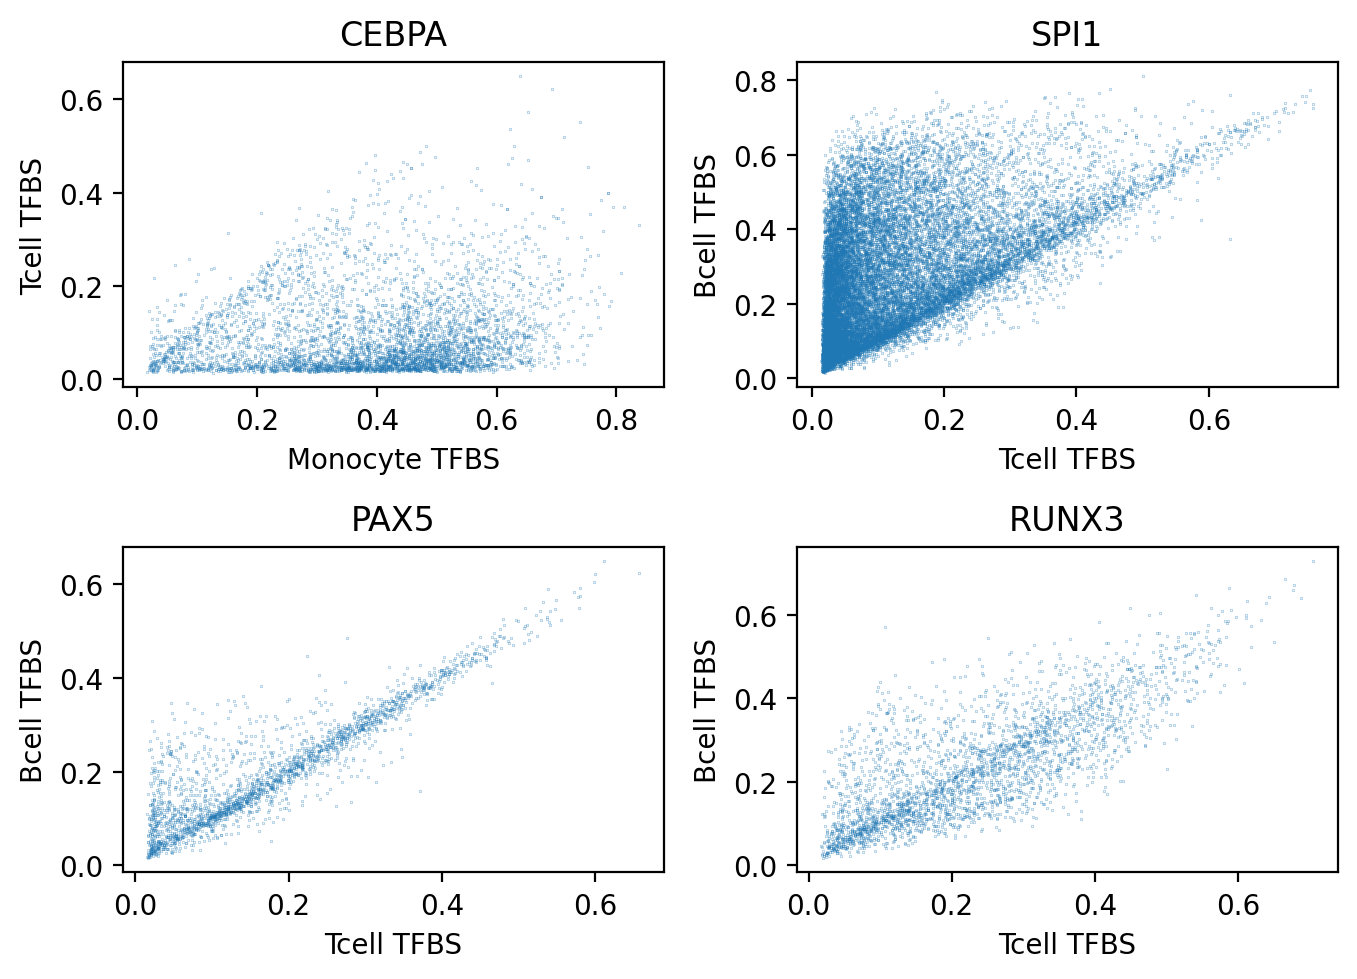

In [58]:
fig, ax = plt.subplots(2,2, figsize=(7,5), dpi=200)
Tcell_selected_pbulks = [i for i in selected_pbulks if "T" in i]
Bcell_selected_pbulks = [i for i in selected_pbulks if "B" in i]
Monocyte_selected_pbulks = [i for i in selected_pbulks if "Mono" in i]

scores = TFBS_scores.loc[TFBS_scores.TF.values == "CEBPA", :]
ax[0][0].scatter(
    np.mean(scores.loc[:, [f"TFBS_{i}" for i in Monocyte_selected_pbulks]], axis=1), 
    np.mean(scores.loc[:, [f"TFBS_{i}" for i in Tcell_selected_pbulks]], axis=1), s=0.01)
ax[0][0].set_xlabel("Monocyte TFBS")
ax[0][0].set_ylabel("Tcell TFBS")
ax[0][0].set_title("CEBPA")
plt.tight_layout()

scores = TFBS_scores.loc[TFBS_scores.TF.values == "SPI1", :]
ax[0][1].scatter(
    np.mean(scores.loc[:, [f"TFBS_{i}" for i in Tcell_selected_pbulks]], axis=1), 
    np.mean(scores.loc[:, [f"TFBS_{i}" for i in Bcell_selected_pbulks]], axis=1), s=0.01)
ax[0][1].set_xlabel("Tcell TFBS")
ax[0][1].set_ylabel("Bcell TFBS")
ax[0][1].set_title("SPI1")
plt.tight_layout()

scores = TFBS_scores.loc[TFBS_scores.TF.values == "PAX5", :]
ax[1][0].scatter(
    np.mean(scores.loc[:, [f"TFBS_{i}" for i in Tcell_selected_pbulks]], axis=1), 
    np.mean(scores.loc[:, [f"TFBS_{i}" for i in Bcell_selected_pbulks]], axis=1), s=0.01)
ax[1][0].set_xlabel("Tcell TFBS")
ax[1][0].set_ylabel("Bcell TFBS")
ax[1][0].set_title("PAX5")
plt.tight_layout()

scores = TFBS_scores.loc[TFBS_scores.TF.values == "RUNX3", :]
ax[1][1].scatter(
    np.mean(scores.loc[:, [f"TFBS_{i}" for i in Tcell_selected_pbulks]], axis=1), 
    np.mean(scores.loc[:, [f"TFBS_{i}" for i in Bcell_selected_pbulks]], axis=1), s=0.01)
ax[1][1].set_xlabel("Tcell TFBS")
ax[1][1].set_ylabel("Bcell TFBS")
ax[1][1].set_title("RUNX3")

plt.show()

From the above results we clearly see that the model predicts elevated binding of CEBPA in monocytes compared to T cells, as well as higher binding of SPI1 in B cells compared to T cells, higher binding of PAX5 in B cells compared to T cells, and higher binding of RUNX in T cells compared to B cells. From the scatter plot, it was a bit hard to see whether RUNX overall gained binding or lost binding in T cells compared to B cells, so now we calculate the difference of binding at each site, and compare all sites where the absolute value of change is above a certain threhsold (let's do 0.05 for now), and then it becomes clear that RUNX binding is higher in T cells.

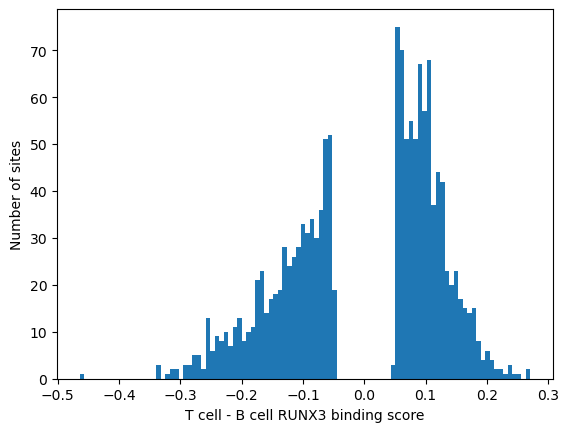

In [59]:
TF = "RUNX3"
scores = TFBS_scores.loc[TFBS_scores.TF.values == TF, :]
Tcell_scores = np.mean(scores.loc[:, [f"TFBS_{i}" for i in Tcell_selected_pbulks]], axis=1)
Bcell_scores = np.mean(scores.loc[:, [f"TFBS_{i}" for i in Bcell_selected_pbulks]], axis=1)
diff = Tcell_scores - Bcell_scores
diff = diff[np.abs(diff) > 0.05]
plt.hist(diff, bins=100)
plt.xlabel(f"T cell - B cell {TF} binding score")
plt.ylabel("Number of sites")
plt.show()

Even though seq2PRINT improved significantly compared to previous methods, **it is important to be aware the caveates and limitations** of our method: although binding prediction is accurate for most TFs, there are TFs that seq2PRINT learns less well, potentially including TFs with very few motif sites in the genome (limiting number of training examples), or TFs that do  not have a strong association with multi-scale footprint patters (if a TF only affects gene expression but not any visible footprints, then seq2PRINT by design will be underpowered to detect its binding). Additionally, TFs in the same family might share similar motifs, so sometimes the TF binding score for one TF might be confounded by binding changes of another family member. Nonetheless, seq2PRINT should help you narrow down the search from a large number of TFs to a short list of interesting candidates.

**Always, always remember to close the object!**

In [60]:
printer.close()

We hope this tutorial is helpful for you and if you run into any issues please feel free to open a GitHub issue at https://github.com/buenrostrolab/scPrinter!